In [1]:
__version__ = "1.3.0"
import arviz as az
import pandas as pd
import numpy as np
from collections import defaultdict
from statistics import mean, variance
from pathlib import Path
from IPython.display import HTML, display
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import matplotlib.pyplot as plt
#from itertools import chain
from pprint import pprint
import seaborn as sns
#%matplotlib inline
#from scipy.special import gammaln, psi, factorial
#from scipy.optimize import fmin_l_bfgs_b as optim
import pymc3 as pm
import re
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [2]:
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, var_names=varnames, figsize=(12, nrows*1.4),
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(trcs, varnames=varnames).iterrows()]))

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i, 0].annotate('{:.2f}'.format(mn), xy=(mn, 0), xycoords='data',
                          xytext=(5, 10), textcoords='offset points', rotation=90,
                          va='bottom', fontsize='large', color='#AA0022')


def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log', rv.name) or re.search('_interval', rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [3]:
np.random.seed(2018)

In [4]:
headers = ['innings', 'ball', 'team', 'batsman', 'batsman_two', 'bowler', 'runs', 'extras', 'out', 'player_out']
home_grounds = {
    'Adelaide Strikers': 'Karen Rolton Oval',
    'Brisbane Heat': 'Allan Border Field',
    'Hobart Hurricanes': 'Bellerive Oval',
    'Melbourne Renegades': 'Junction Oval',
    'Melbourne Stars': 'Junction Oval',
    'Perth Scorchers': 'Lilac Hill Park',
    'Sydney Sixers': 'North Sydney Oval',
    'Sydney Thunder': 'Blacktown International Sportspark'
}

In [5]:
def iter_csvs():
    return list(Path('./data/').rglob('*.csv'))

local_csvs = iter_csvs()

In [6]:
def ingest_csv(csv_path_obj):
    with open(str(csv_path_obj), 'r') as fh:
        data = [l.split(',') for l in fh.read().split('\n') if l]
    info, balls = {}, []
    info['fname'] = str(csv_path_obj)
    for line in data:
        if line[0] == 'version':
            assert line[1] == __version__
        elif line[0] == 'info':
            if line[1] in info.keys():
                info[f'{line[1]}_two'] = line[2]
            else:
                info[line[1]] = line[2]
        elif line[0] == 'ball':
            ball = dict(zip(headers, [l.replace('"', '') for l in line[1:]]))
            balls.append(ball)
    info['balls'] = balls
    return info

def ingest_csvs(csvs):
    return [ingest_csv(csv) for csv in csvs]

entire_data = ingest_csvs(local_csvs)
latest_season = sorted(list(set([e['season'].strip() for e in entire_data])))[-1]

In [8]:
# Here we set up some variables that we think could impact the likelihood of
# scoring a six off any given ball. Each is given by a function to return
# a truthy value.

# did_score_run
def did_score_run(ball):
    return int(ball['runs']) > 0

# first_ball_of_over
def first_ball_of_over(ball):
    return ball['ball'].split('.')[-1] == '1'
        
# last_ball_of_over
def last_ball_of_over(ball, balls):
    curr = [
        b
        for b
        in balls
        if b['innings'] == ball['innings']
        and b['ball'].split('.')[0] == ball['ball'].split('.')[0]
    ]
    return curr.index(ball) + 1 == len(curr)

# first_over_of_innings
def first_over_of_innings(ball):
    return ball['ball'].split('.')[0] == '0'

# last_over_of_innings
def last_over_of_innings(ball, balls):
    curr = [b for b in balls if b['innings'] == ball['innings']]
    return curr.index(ball) + 1 == len(curr)

# first_innings
def first_innings(ball):
    return ball['innings'] == '1'

# won_toss
def won_toss(ball, game):
    return ball['team'] == game['toss_winner']

# bat_first
def bat_first(ball, game):
    if won_toss(ball, game):
        if game['toss_decision'] == 'field':
            return False
        return True
    else:
        if game['toss_decision'] == 'field':
            return True
        return False

# playing_at_home
def playing_at_home(ball, game):
    return home_grounds.get(ball['team'], '') in game['venue']
    
# first_match_of_season
def first_match_of_season(ball, game):
    return game.get('match_number', '') == '1'

# is semi or final
# a match is a final or semi final if it does not have a match number. 
# there are 2 of these per season - one for the finalists and one for the runners-up.
def is_semi_or_final(ball, game):
    return game.get('match_number', '') == ''

test_game = entire_data[0]
test_ball = test_game['balls'][20]
#print(test_game)
print(test_ball)
print('did score run', did_score_run(test_ball))
print('first ball over', first_ball_of_over(test_ball))
print('last ball over', last_ball_of_over(test_ball, test_game['balls']))
print('first over of innings', first_over_of_innings(test_ball))
print('last over of innings', last_over_of_innings(test_ball, test_game['balls']))
print('first_innings', first_innings(test_ball))
print('won toss', won_toss(test_ball, test_game))
print('bat first', bat_first(test_ball, test_game))
print('playing at home', playing_at_home(test_ball, test_game))
print('first match', first_match_of_season(test_ball, test_game))
print('is semi or final', is_semi_or_final(test_ball, test_game))

{'innings': '1', 'ball': '3.1', 'team': 'Sydney Sixers', 'batsman': 'EA Perry', 'batsman_two': 'A Gardner', 'bowler': 'B Vakarewa', 'runs': '0', 'extras': '0', 'out': '', 'player_out': ''}
did score run False
first ball over True
last ball over False
first over of innings False
last over of innings False
first_innings True
won toss True
bat first True
playing at home False
first match False
is semi or final False


In [9]:
#all_balls_ever = []
all_scores_ever = []
for game in entire_data:
    if game.get('outcome', '') != 'no result' and game.get('winner', None) is not None:
        a, b = game['team'], game['team_two']
        #print(a, b)
        #print(game['fname'])
        a_balls = [bl for bl in game['balls'] if bl['team'] == a]
        b_balls = [bl for bl in game['balls'] if bl['team'] == b]
        all_scores_ever.append([
            sum([int(bl['runs']) for bl in a_balls]),
            home_grounds.get(a, '') in game['venue'],
            is_semi_or_final(a_balls[0], game),
            first_match_of_season(a_balls[0], game),
            won_toss(a_balls[0], game),
            bat_first(a_balls[0], game),
            a == game['winner'],
            game.get('match_number', ''),
            a
        ])
        all_scores_ever.append([
            sum([int(bl['runs']) for bl in b_balls]),
            home_grounds.get(b, '') in game['venue'],
            is_semi_or_final(b_balls[0], game),
            first_match_of_season(b_balls[0], game),
            won_toss(b_balls[0], game),
            bat_first(b_balls[0], game),
            b == game['winner'],
            game.get('match_number', ''),
            b
        ])
df = pd.DataFrame(all_scores_ever, columns=[
    'run_count',
    'at_home',
    'is_final',
    'first_match',
    'won_toss',
    'bat_first',
    'won',
    'matchnum',
    'team'
])


In [10]:
teams = set([m['team'] for m in entire_data])

In [11]:
print(len(df))

404


In [12]:
df.head()

run_count  at_home  is_final  first_match  won_toss  bat_first    won  \
0        141     True     False        False     False       True  False   
1        139    False     False        False      True      False   True   
2        119    False     False        False      True       True  False   
3        117    False     False        False     False      False   True   
4        103    False     False        False      True       True  False   

  matchnum                 team  
0       51        Sydney Sixers  
1       51  Melbourne Renegades  
2       11        Sydney Sixers  
3       11      Melbourne Stars  
4        8      Melbourne Stars

        run_count
count  404.000000
mean   123.433168
std     26.296043
min     50.000000
25%    106.750000
50%    124.000000
75%    140.250000
max    231.000000


/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


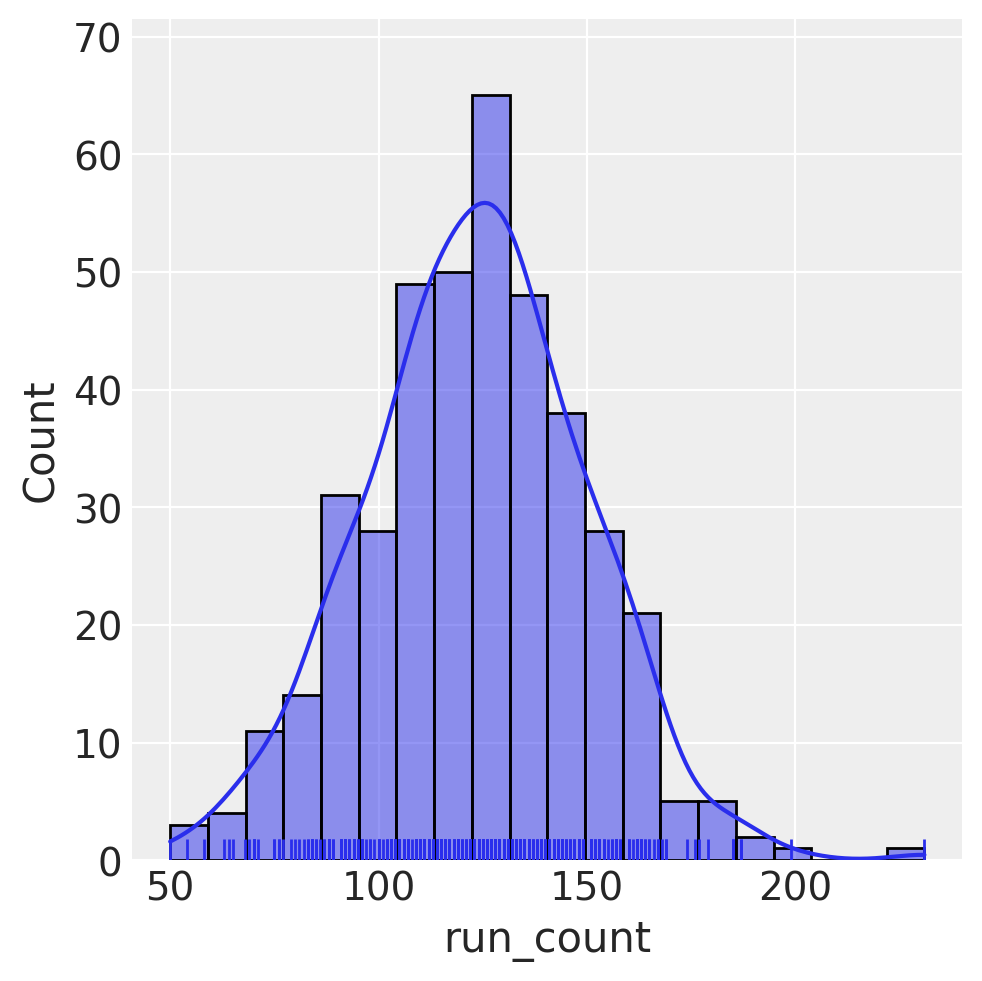

In [13]:
print(df.describe())
ax = sns.displot(df.run_count, rug=True, kde=True)

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


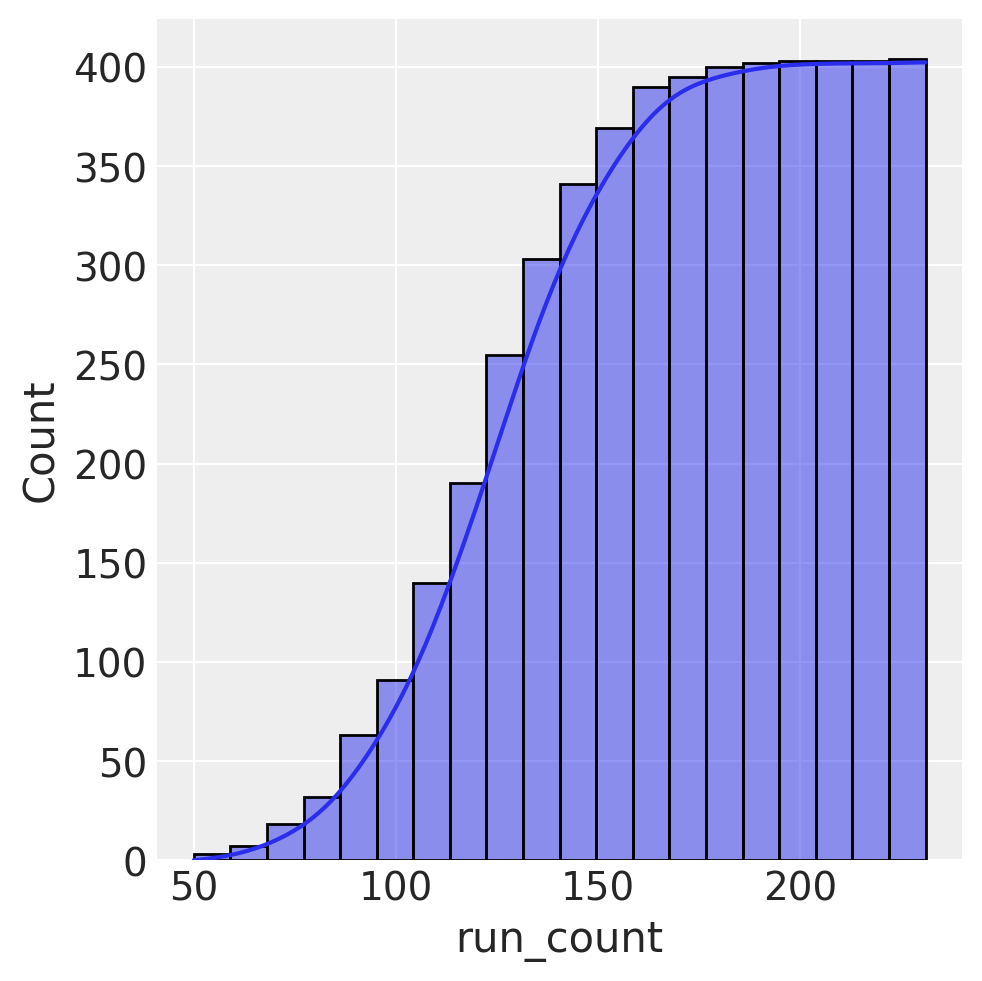

In [39]:
sns.displot(df.run_count, kde=True, cumulative=True)

We hypothesise that batting first will have a significant impact on a team's ability to win - that is, if the team fields first, they are likely to be more tired and less focused when it comes to batting.

Similarly, we anticipate that excitement for the season to begin will amplify scores in the first few games. Inversely, the trepidation for a final might reduce the number of runs scored.

Lastly, we anticipate that having the home field advantage will confer a better chance of scoring more runs in a final; the mental attitude of playing at home should overcome the odds of losing the final.

In [15]:
df.groupby(['bat_first', 'first_match'])['run_count'].agg(['mean', 'var'])

mean         var
bat_first first_match                        
False     False        118.130653  588.386884
          True         153.666667  761.333333
True      False        127.597990  711.675956
          True         168.666667  902.333333

In [16]:
df.groupby(['bat_first', 'is_final'])['run_count'].agg(['mean', 'var'])

mean         var
bat_first is_final                        
False     False     119.063492  593.729990
          True      112.769231  804.358974
True      False     128.391534  748.430992
          True      125.538462  574.769231

In [17]:
df.groupby(['bat_first', 'at_home'])['run_count'].agg(['mean', 'var'])

mean         var
bat_first at_home                        
False     False    116.529412  588.167769
          True     129.968750  564.224798
True      False    126.609467  693.918005
          True     136.393939  889.996212

In [18]:
df.groupby(['is_final', 'at_home'])['run_count'].agg(['mean', 'var'])

mean         var
is_final at_home                        
False    False    121.939683  664.126923
         True     132.666667  741.483871
True     False    116.500000  669.304348
         True     151.000000   18.000000

Our suspicions are seemingly confirmed. Although given that the variance is quite high, even though the data looks Poisson, we'll proceed with a cross-sectional catplot and negative logistic regression.

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


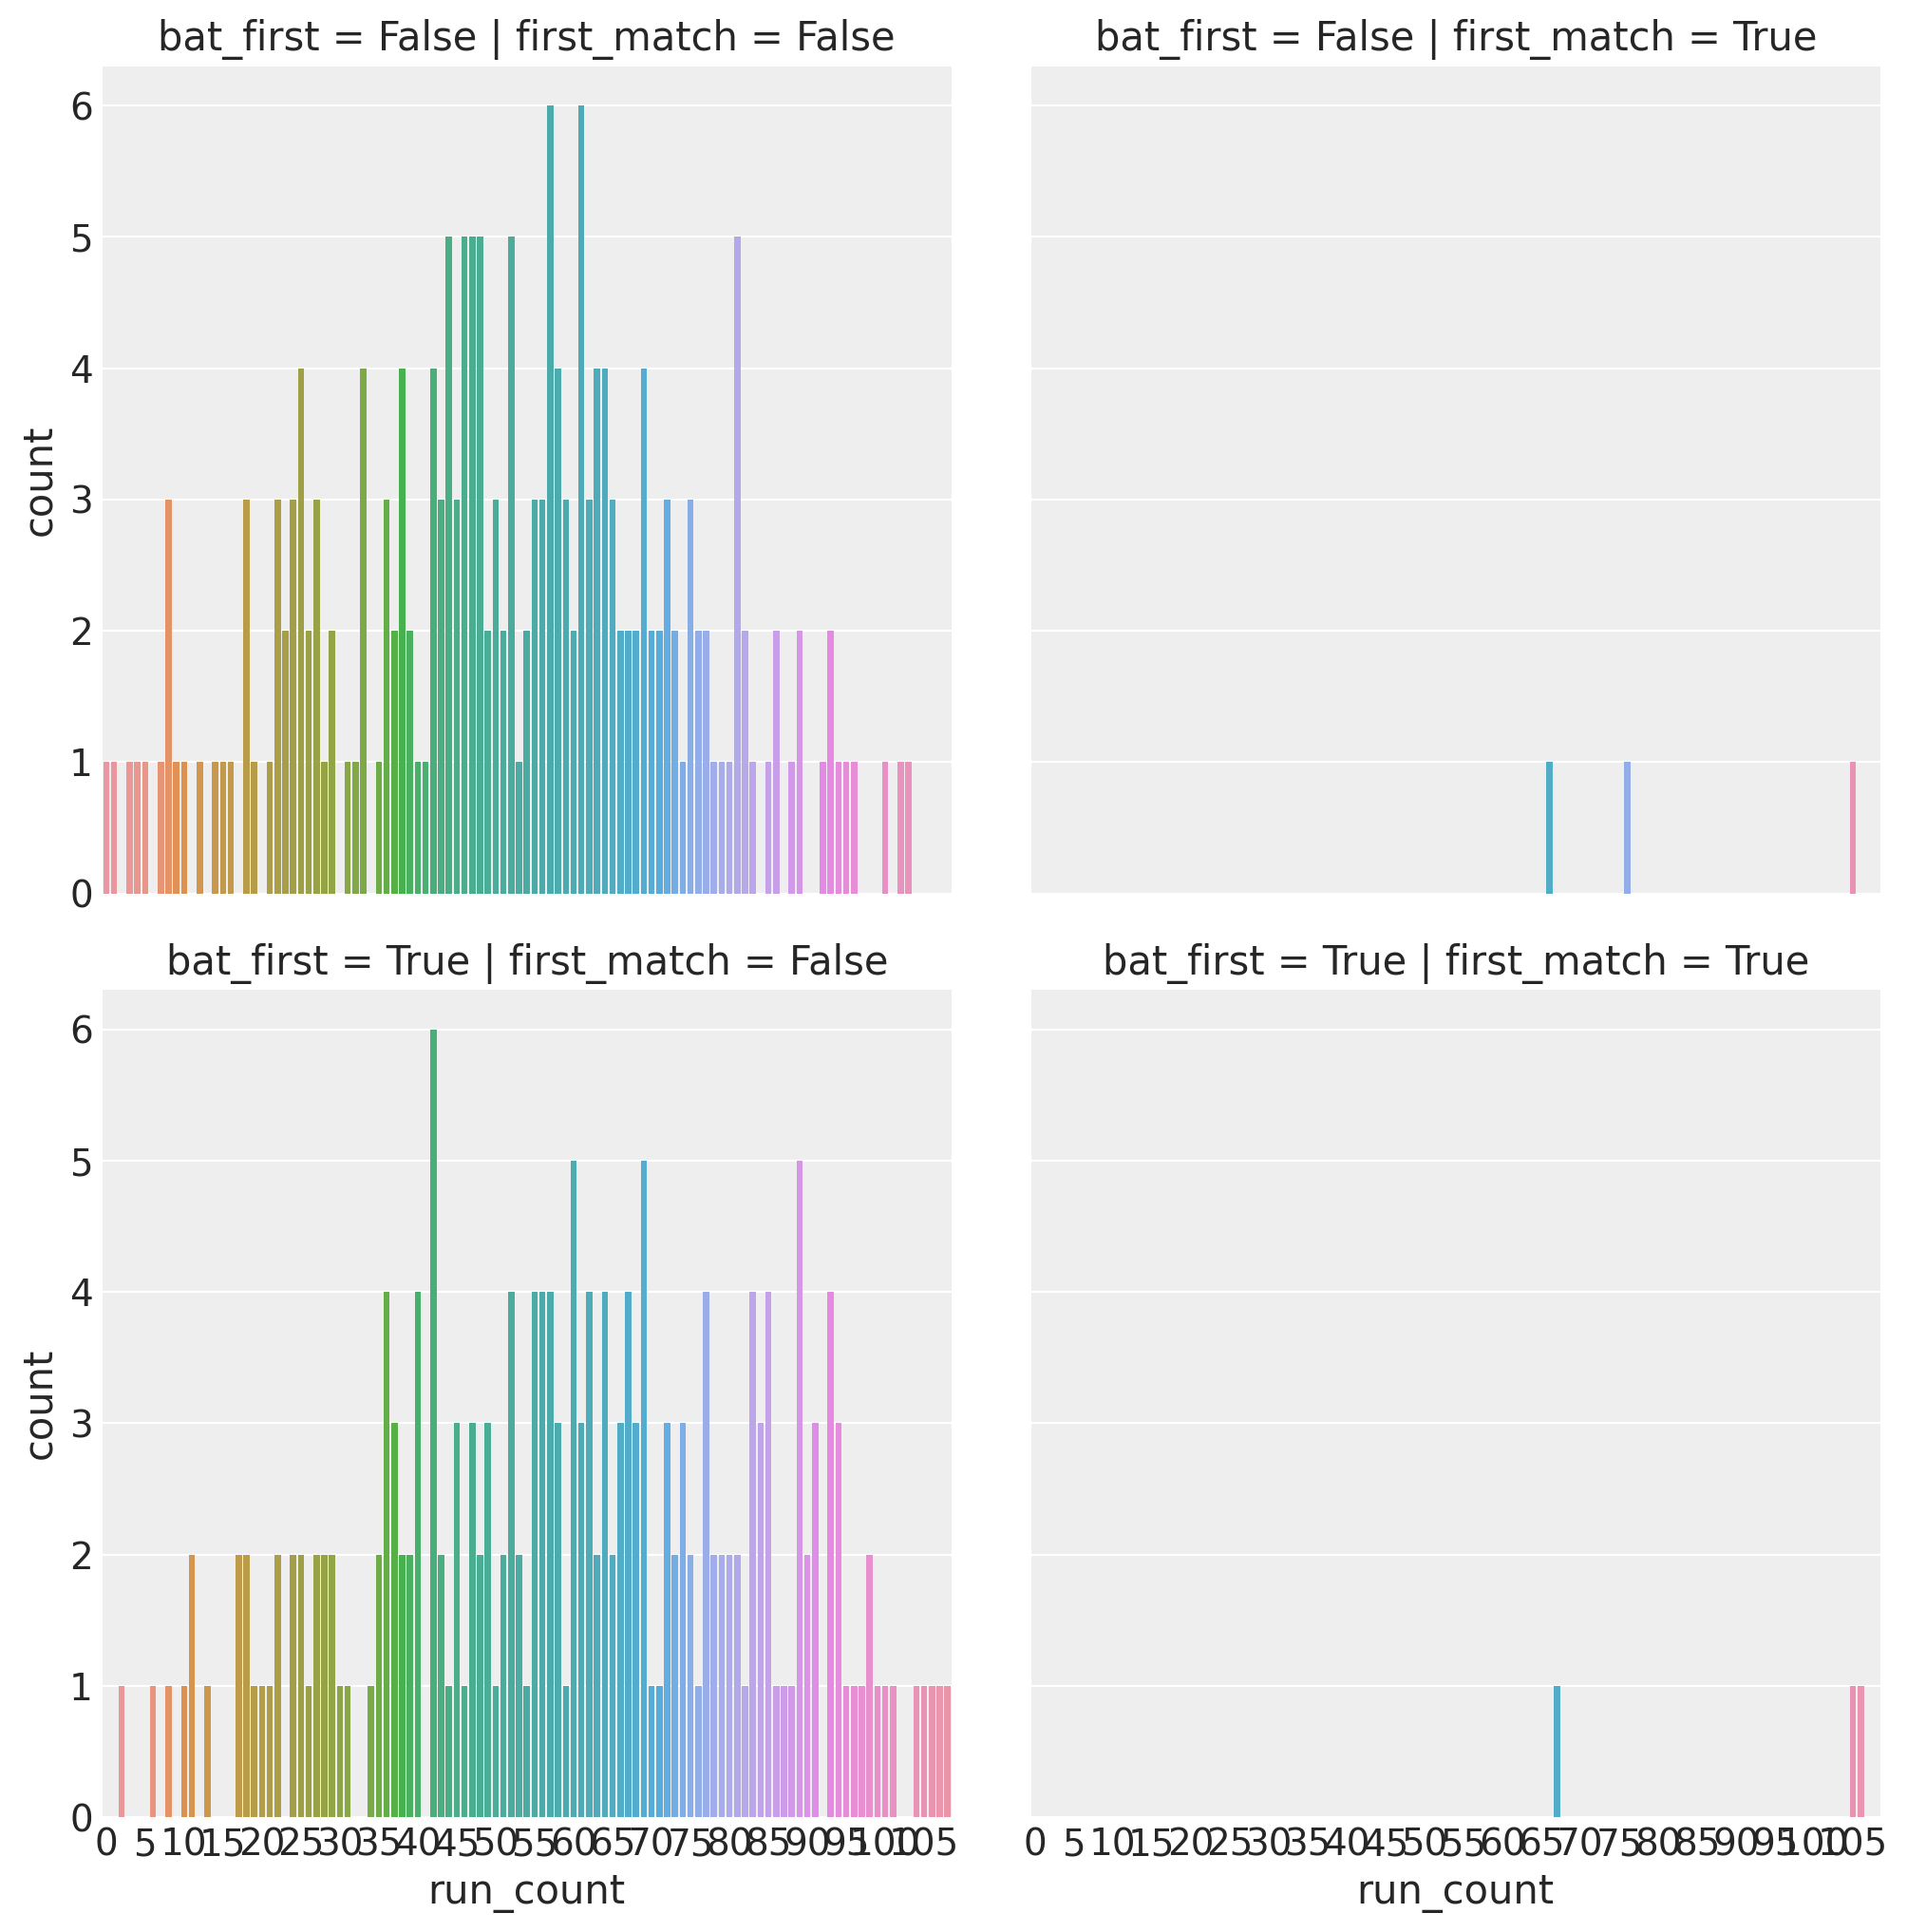

In [19]:
g = sns.catplot(x='run_count', row='bat_first', col='first_match', data=df, kind='count', aspect=1)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

We notice a significant skew toward higher runs if it is the first match. This is regardless of whether the team bats first or not. Note that we have a relatively small sample size.

We also see a significant skew toward batting first as increasing the run count. This is a good sign for our hypothesis.

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


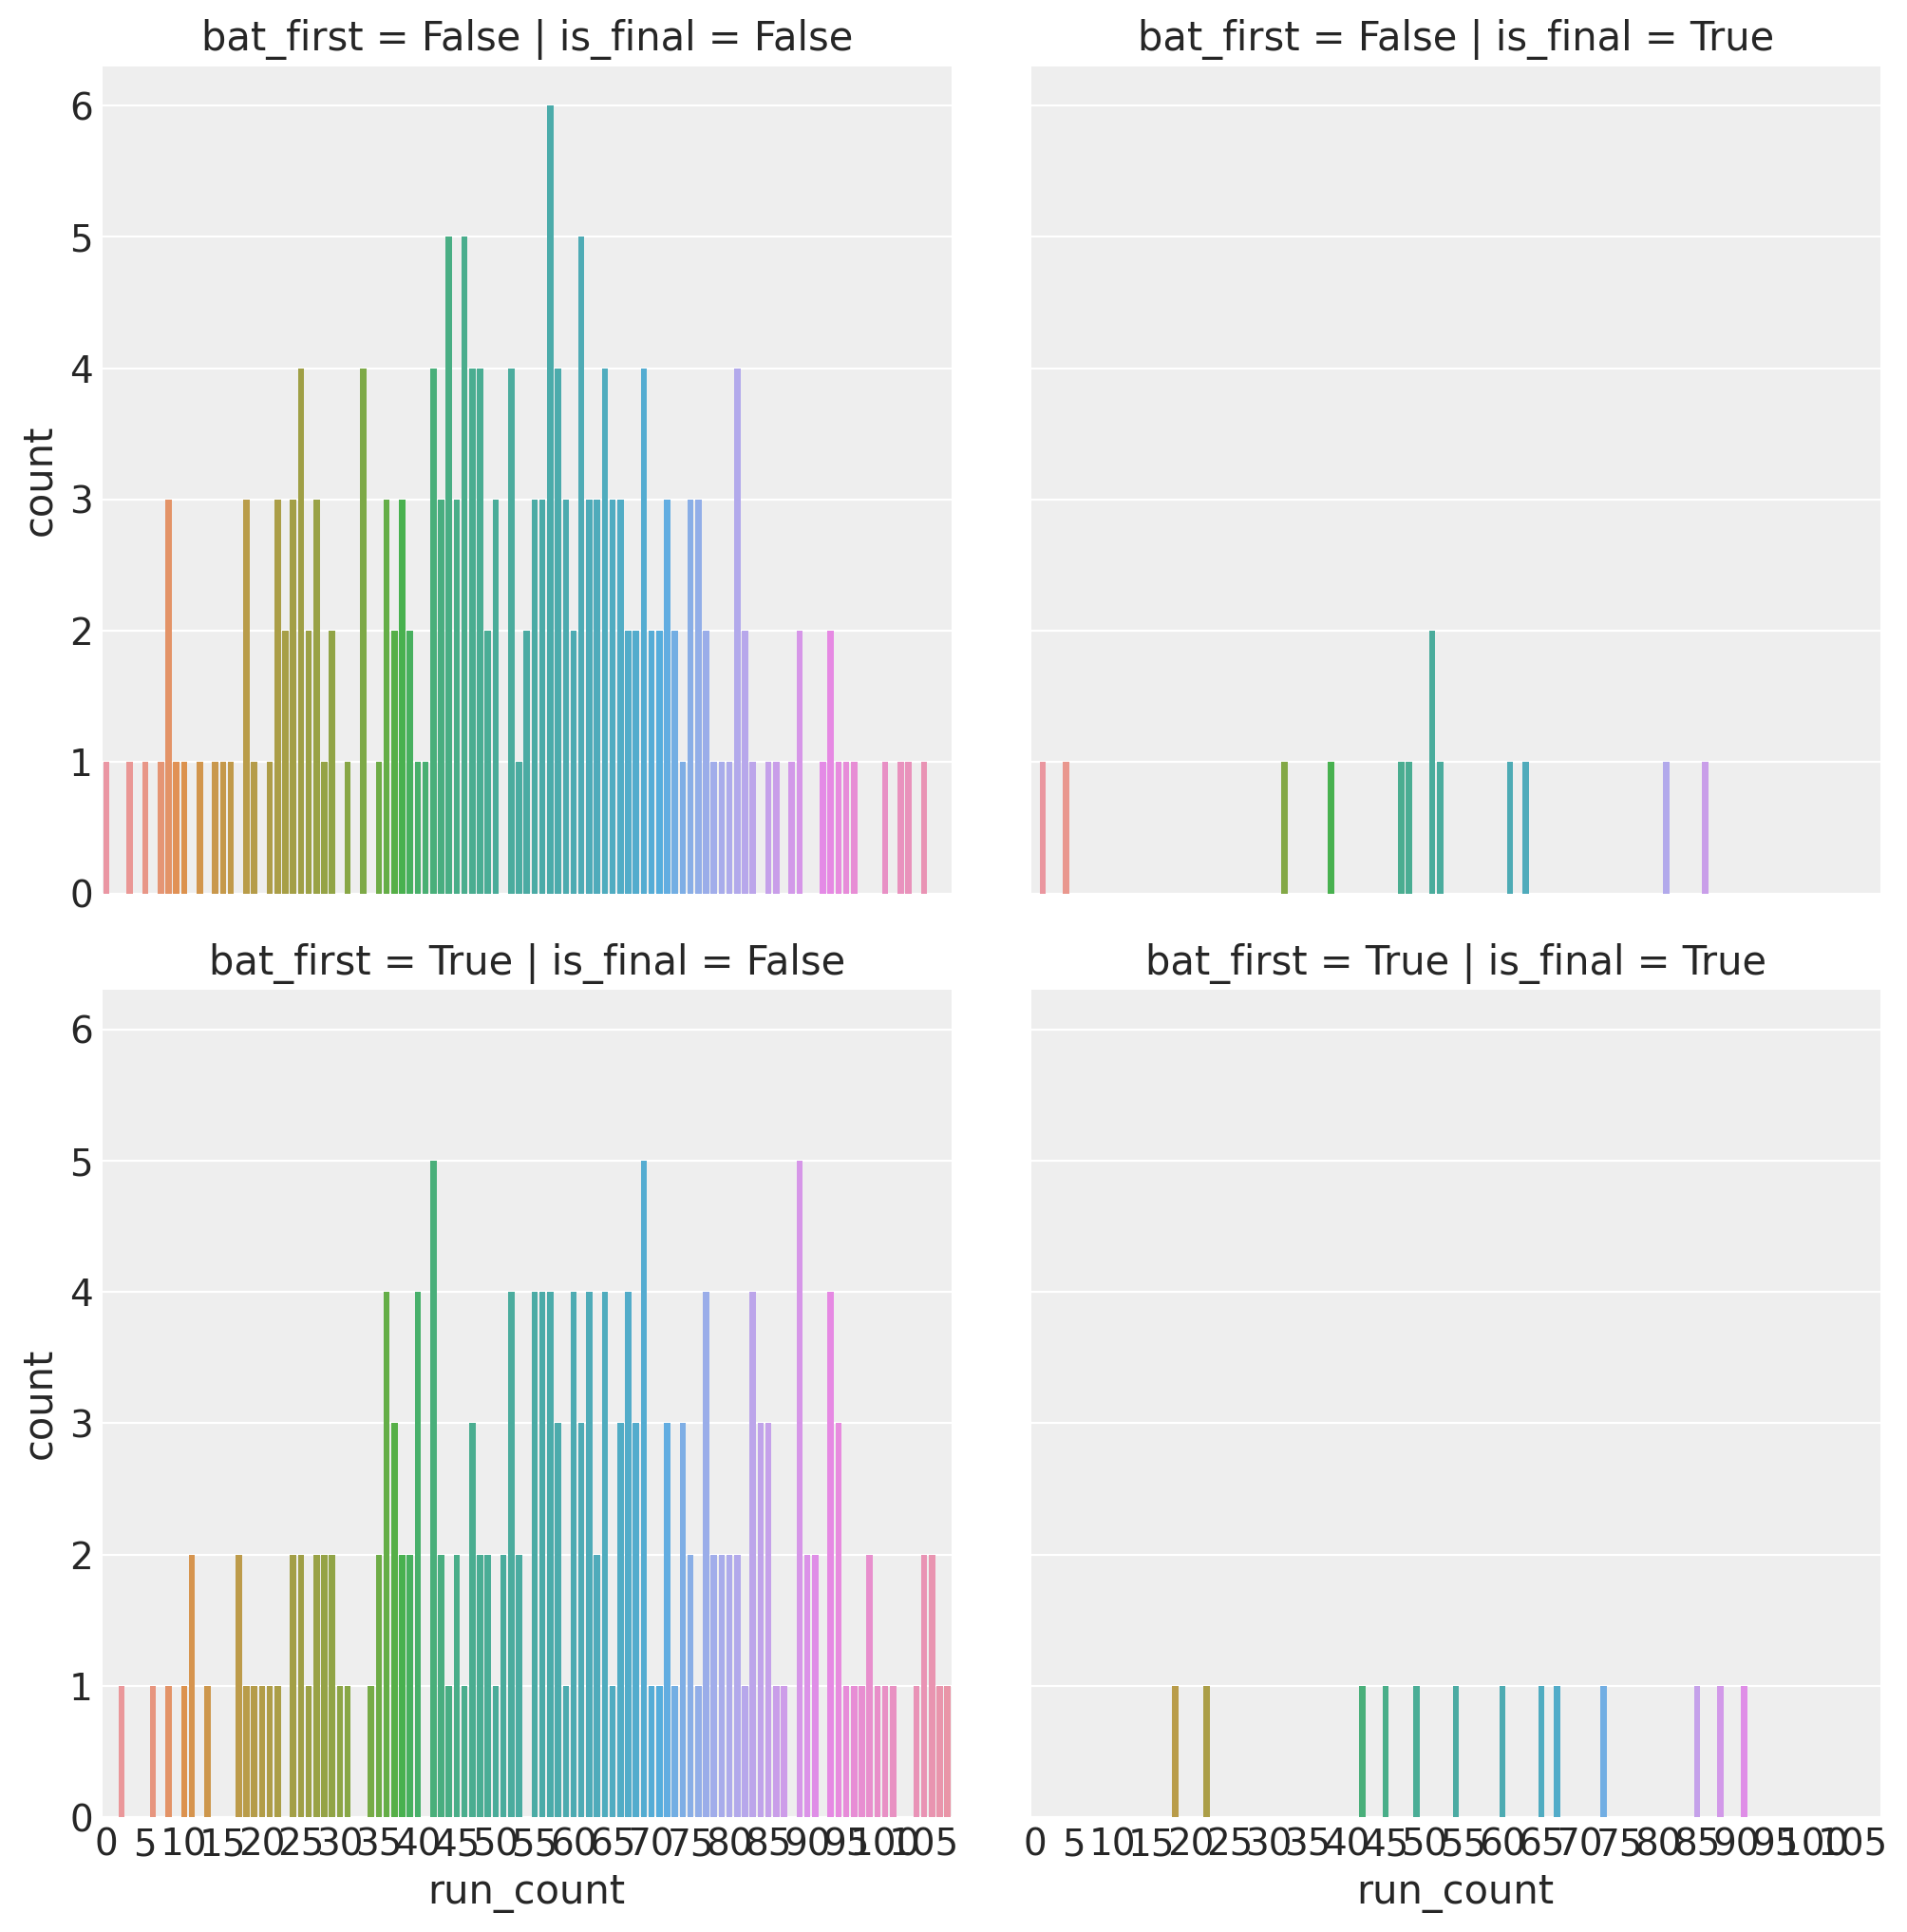

In [20]:
g = sns.catplot(x='run_count', row='bat_first', col='is_final', data=df, kind='count', aspect=1)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

We notice that if not batting first and it's a final game that the data are skewed quite negatively. The positive influence of batting first seems to counteract this in the bottom right quadrant.

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


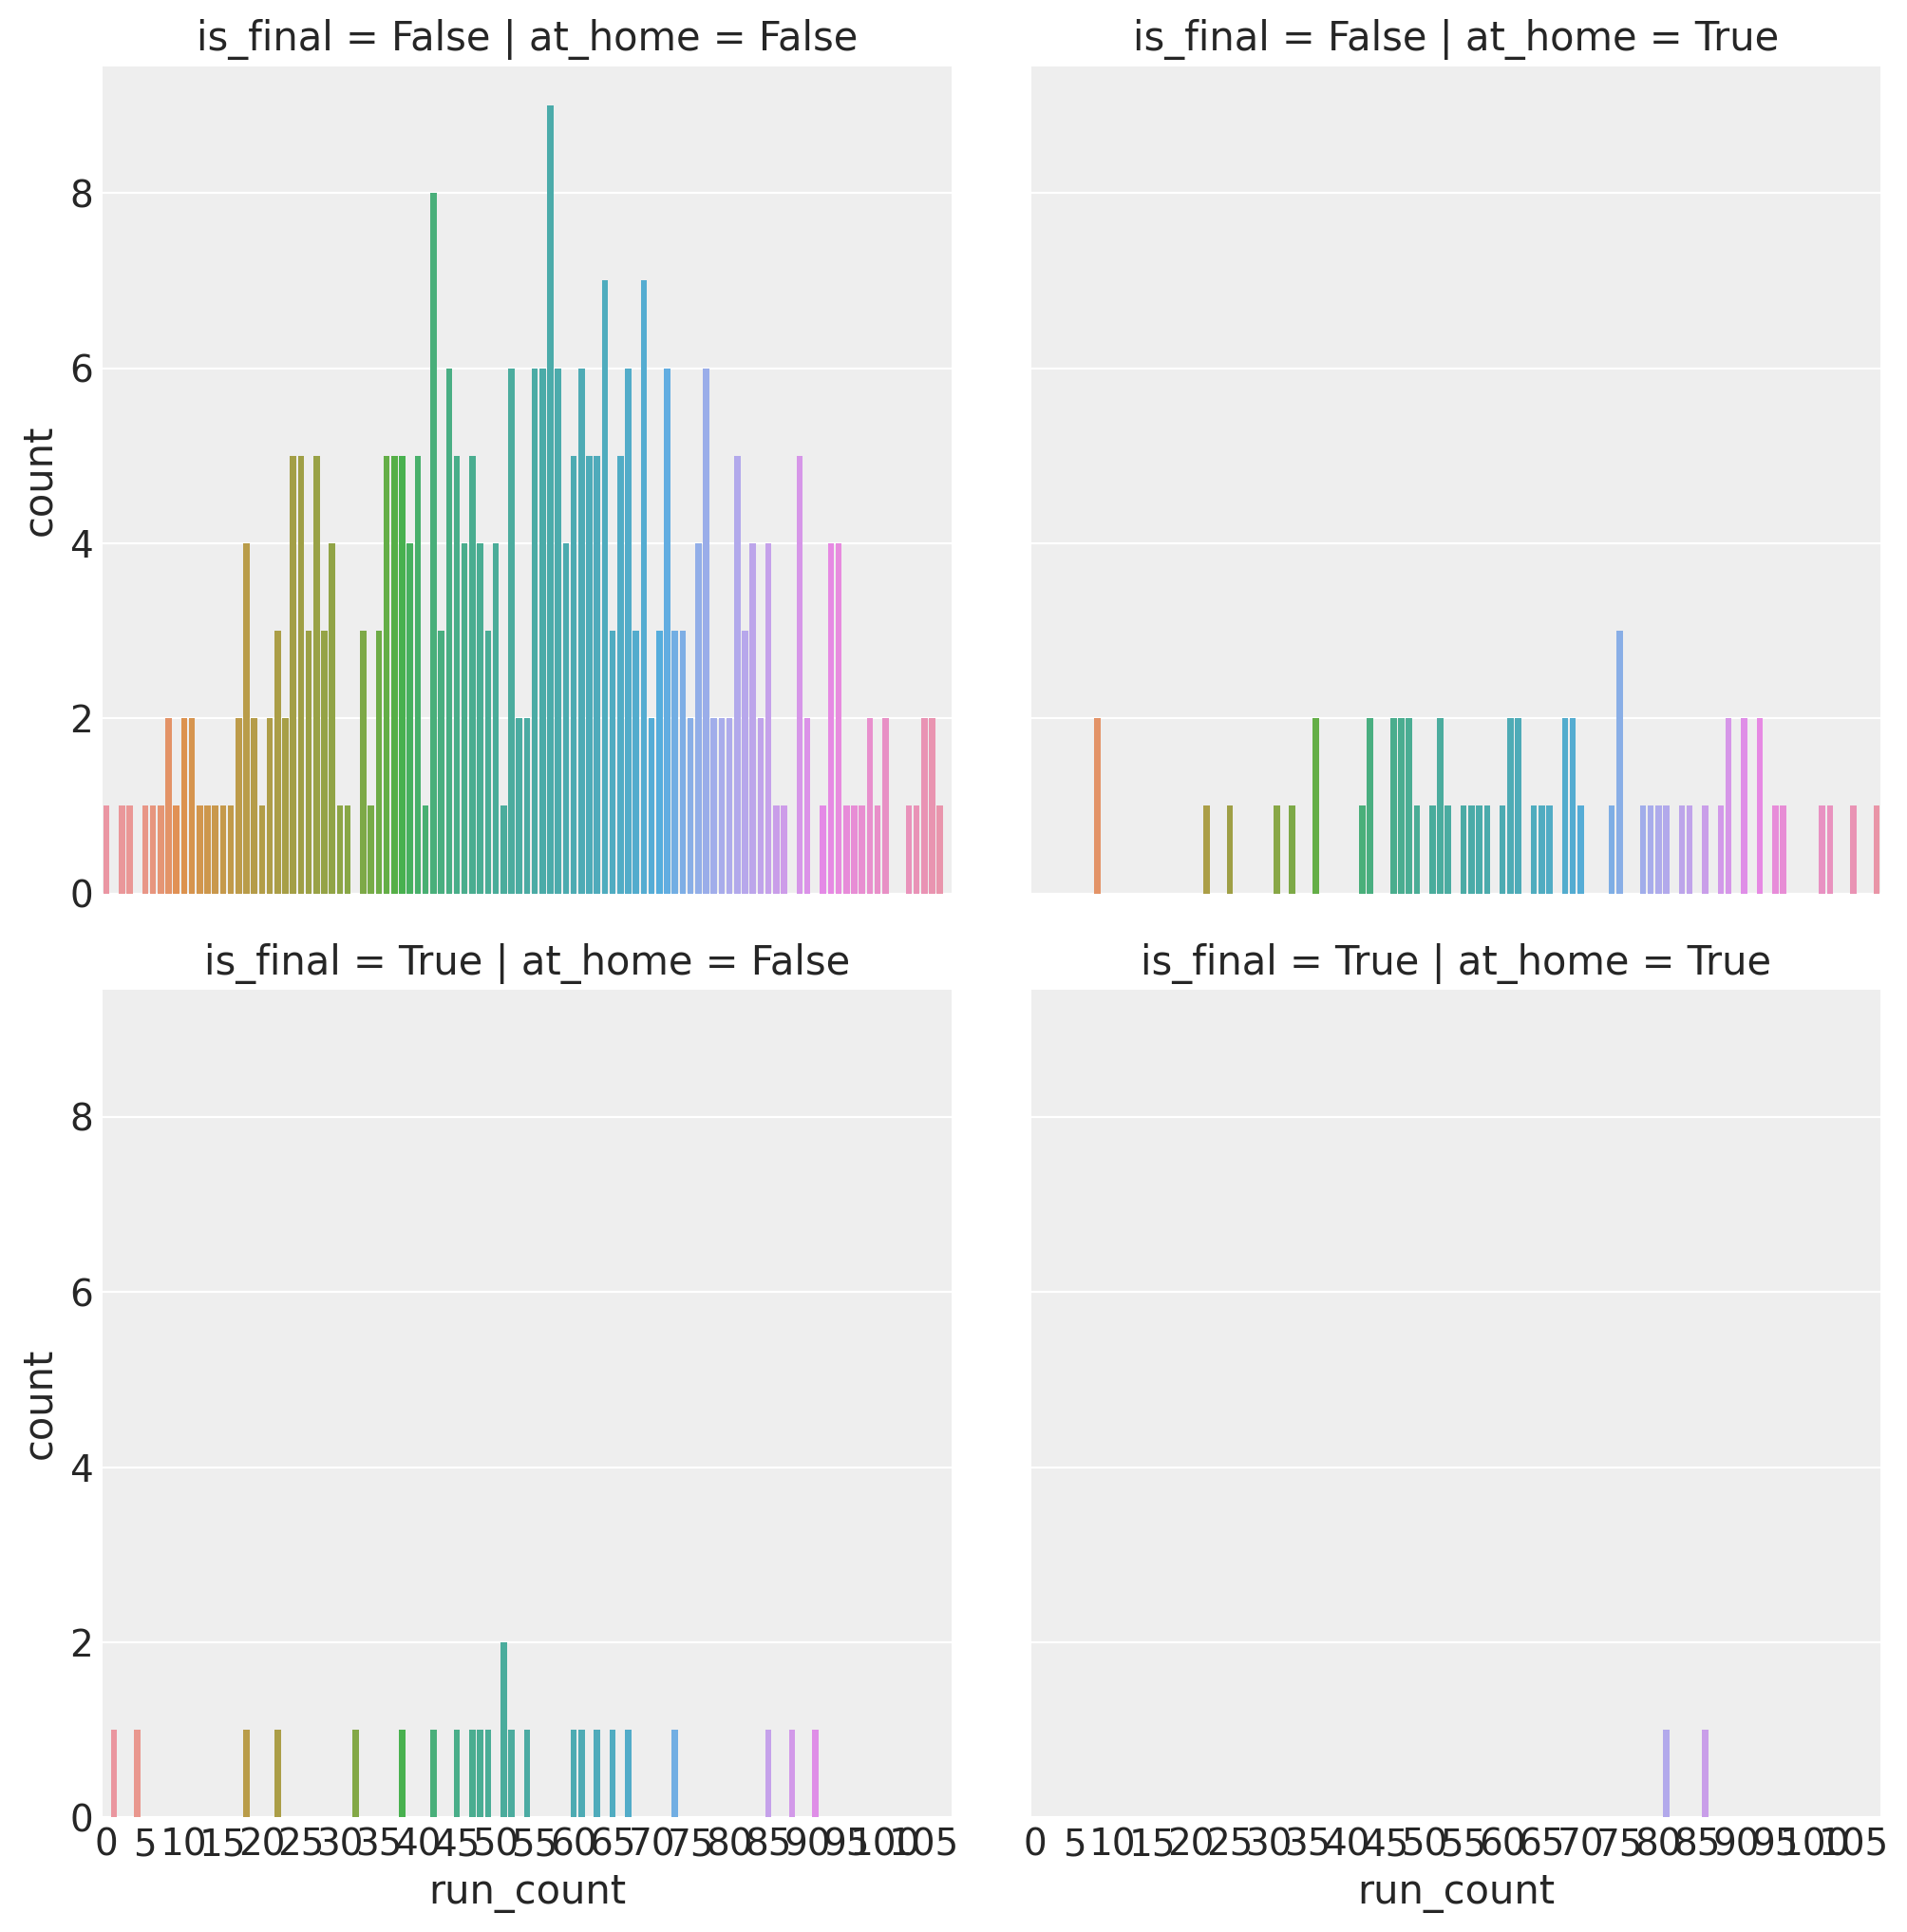

In [21]:
g = sns.catplot(x='run_count', row='is_final', col='at_home', data=df, kind='count', aspect=1)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

For the two lucky teams that have been able to play their final matches at home, it looks like it worked out for them. Though of course this remains to be seen over future seasons.

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


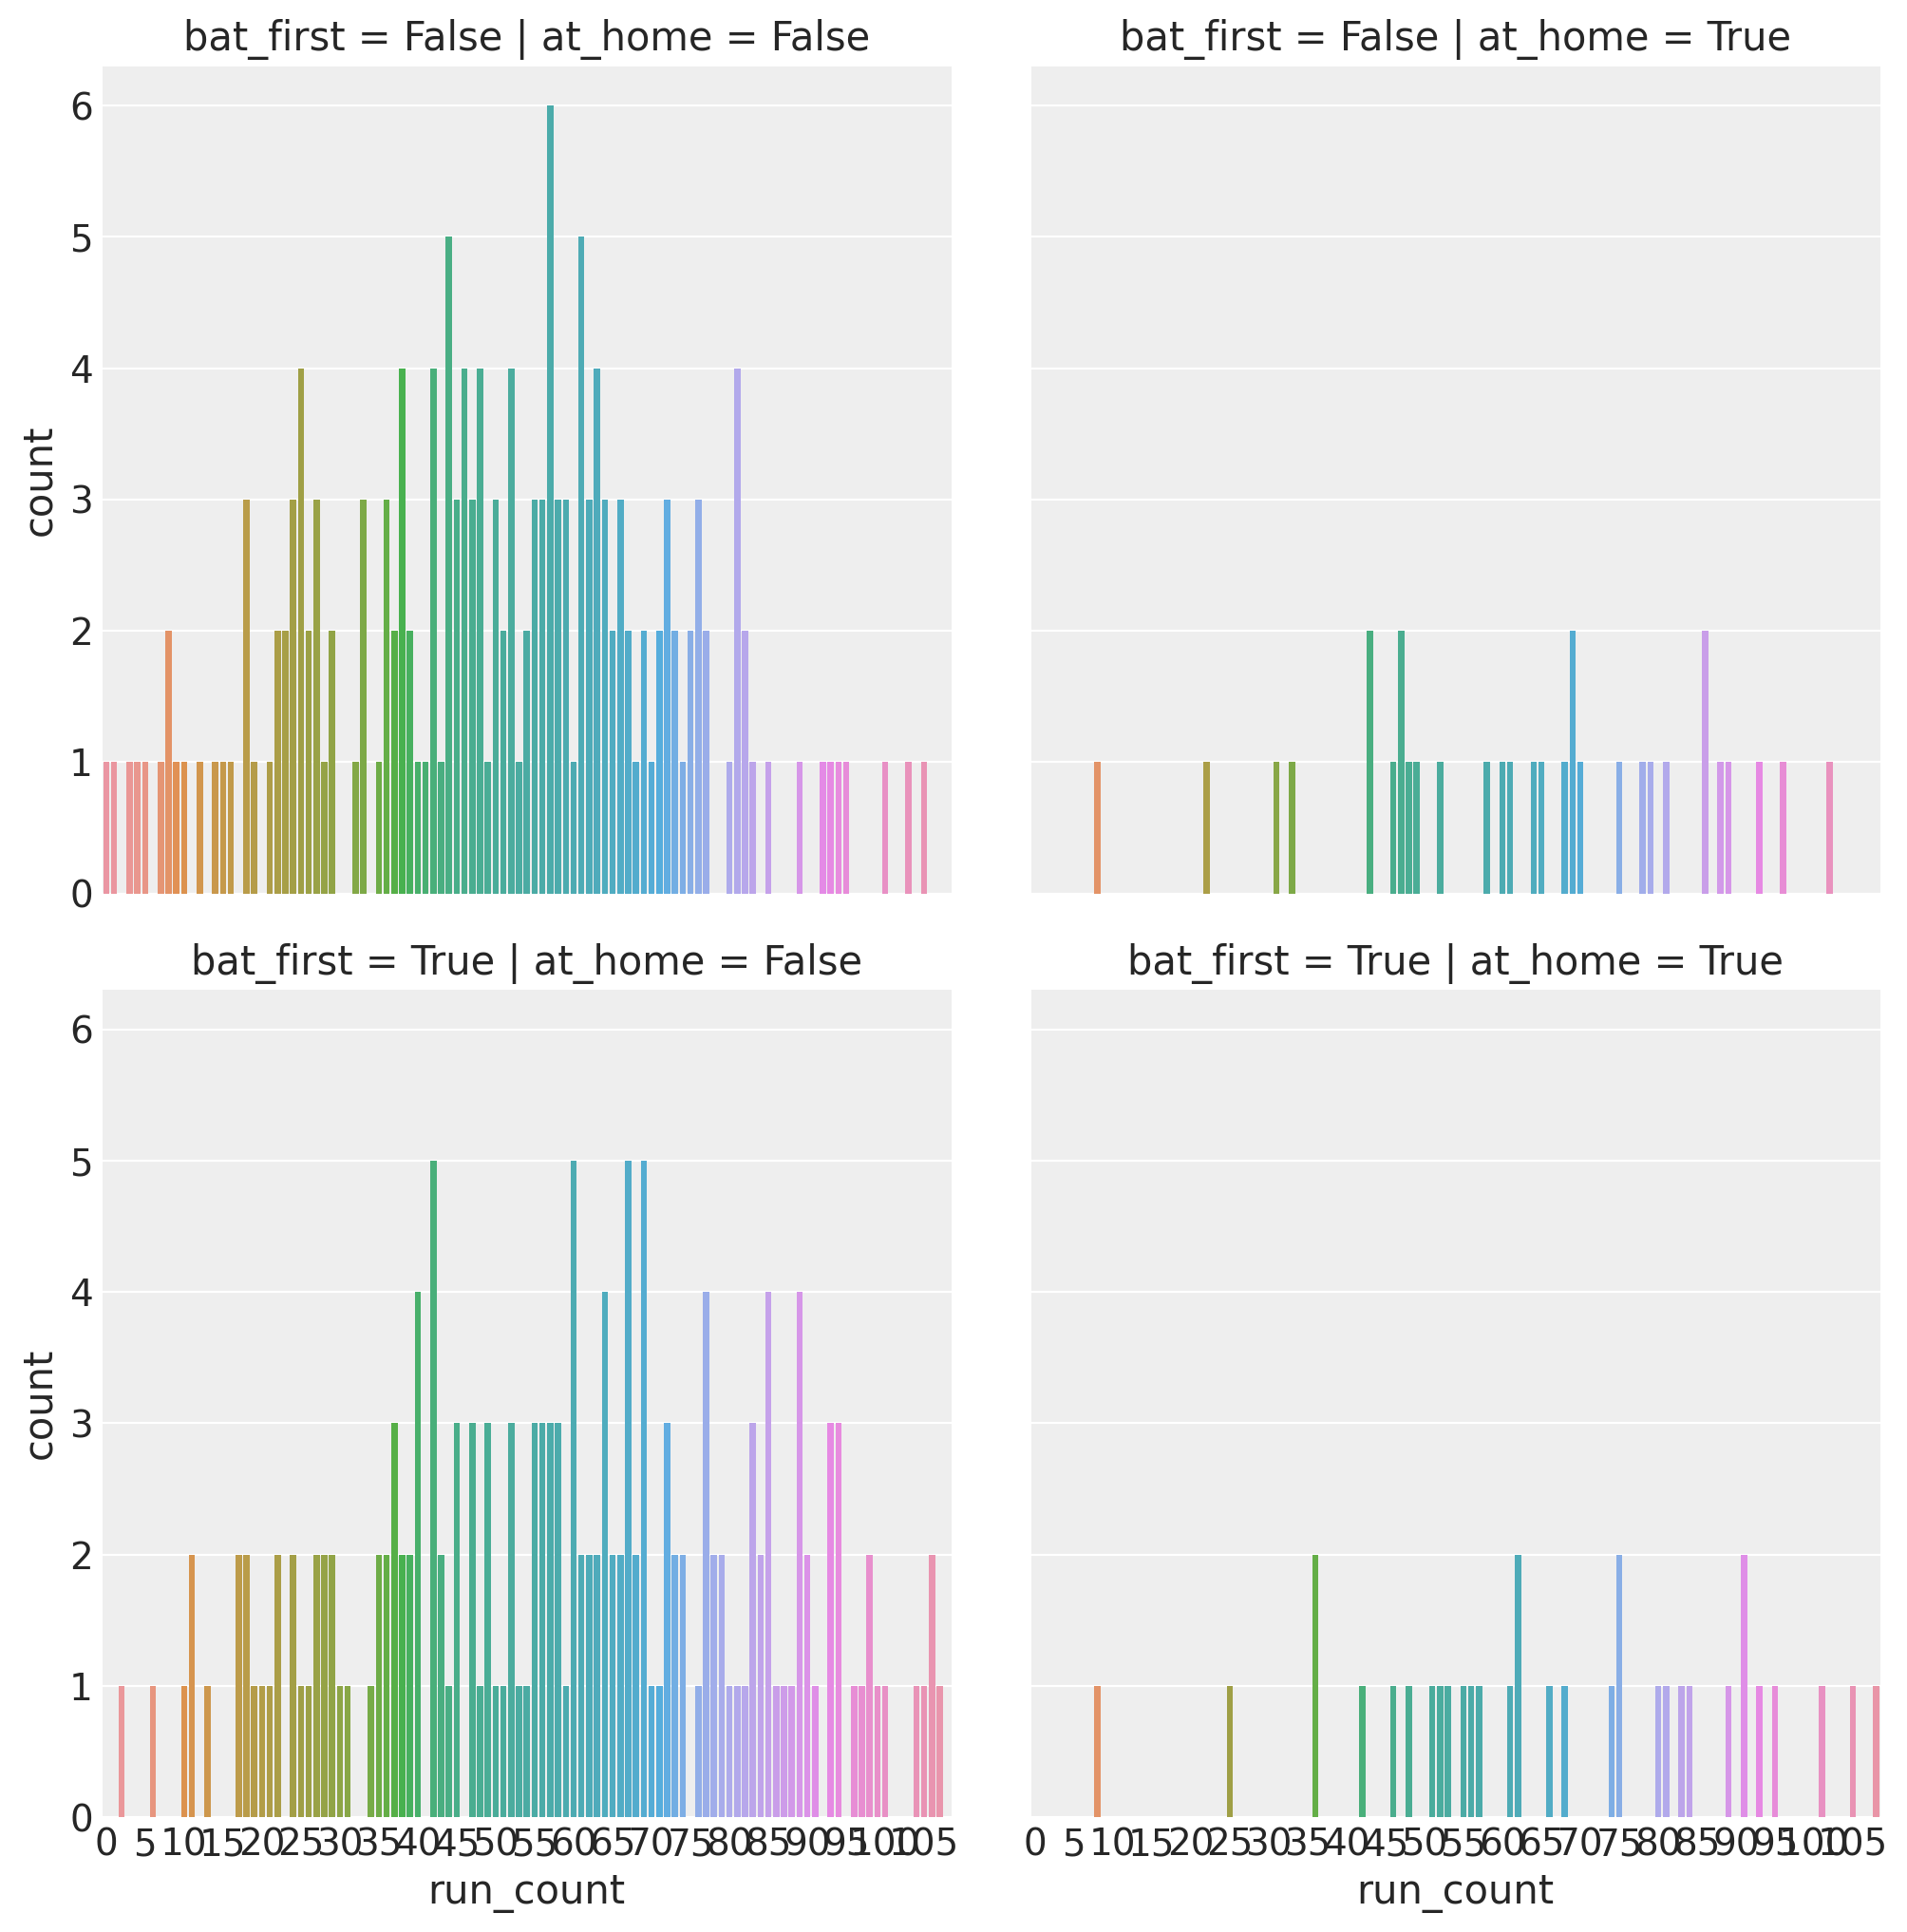

In [22]:
g = sns.catplot(x='run_count', row='bat_first', col='at_home', data=df, kind='count', aspect=1)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

We notice a slight positive skew toward batting at home, and likewise when batting at home and batting first.

We will use the PyMC3 module to evaluate our models. We chose this as it is a good library for allowing us to automatically apply Bayesian statistical models behind-the-scenes. More specifically, we'll use the Hoffman Markov chain Monte Carlo algorithm, the No-U-Turn Sampler (NUTS). This will allow us to iterate over a large set of random samples without spending time computing them manually or worrying about asymptotic bias.

We'll use the built-in Generalized Linear Model, specifically the NegativeBinomial model, as it'll allow us to compare multiple predictors.

In essence: we want to sample multiple Negative Binomial distributions to find an approximate best regression of the Negative Binomial distribution.

For more information, check http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf.


In [23]:
formula = 'run_count ~ bat_first + first_match + bat_first:first_match'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=df, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(1000, tune=1250, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, bat_first[T.True]:first_match[T.True], first_match[T.True], bat_first[T.True], Intercept]


Sampling 2 chains for 1_250 tune and 1_000 draw iterations (2_500 + 2_000 draws total) took 14 seconds.


/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stocha

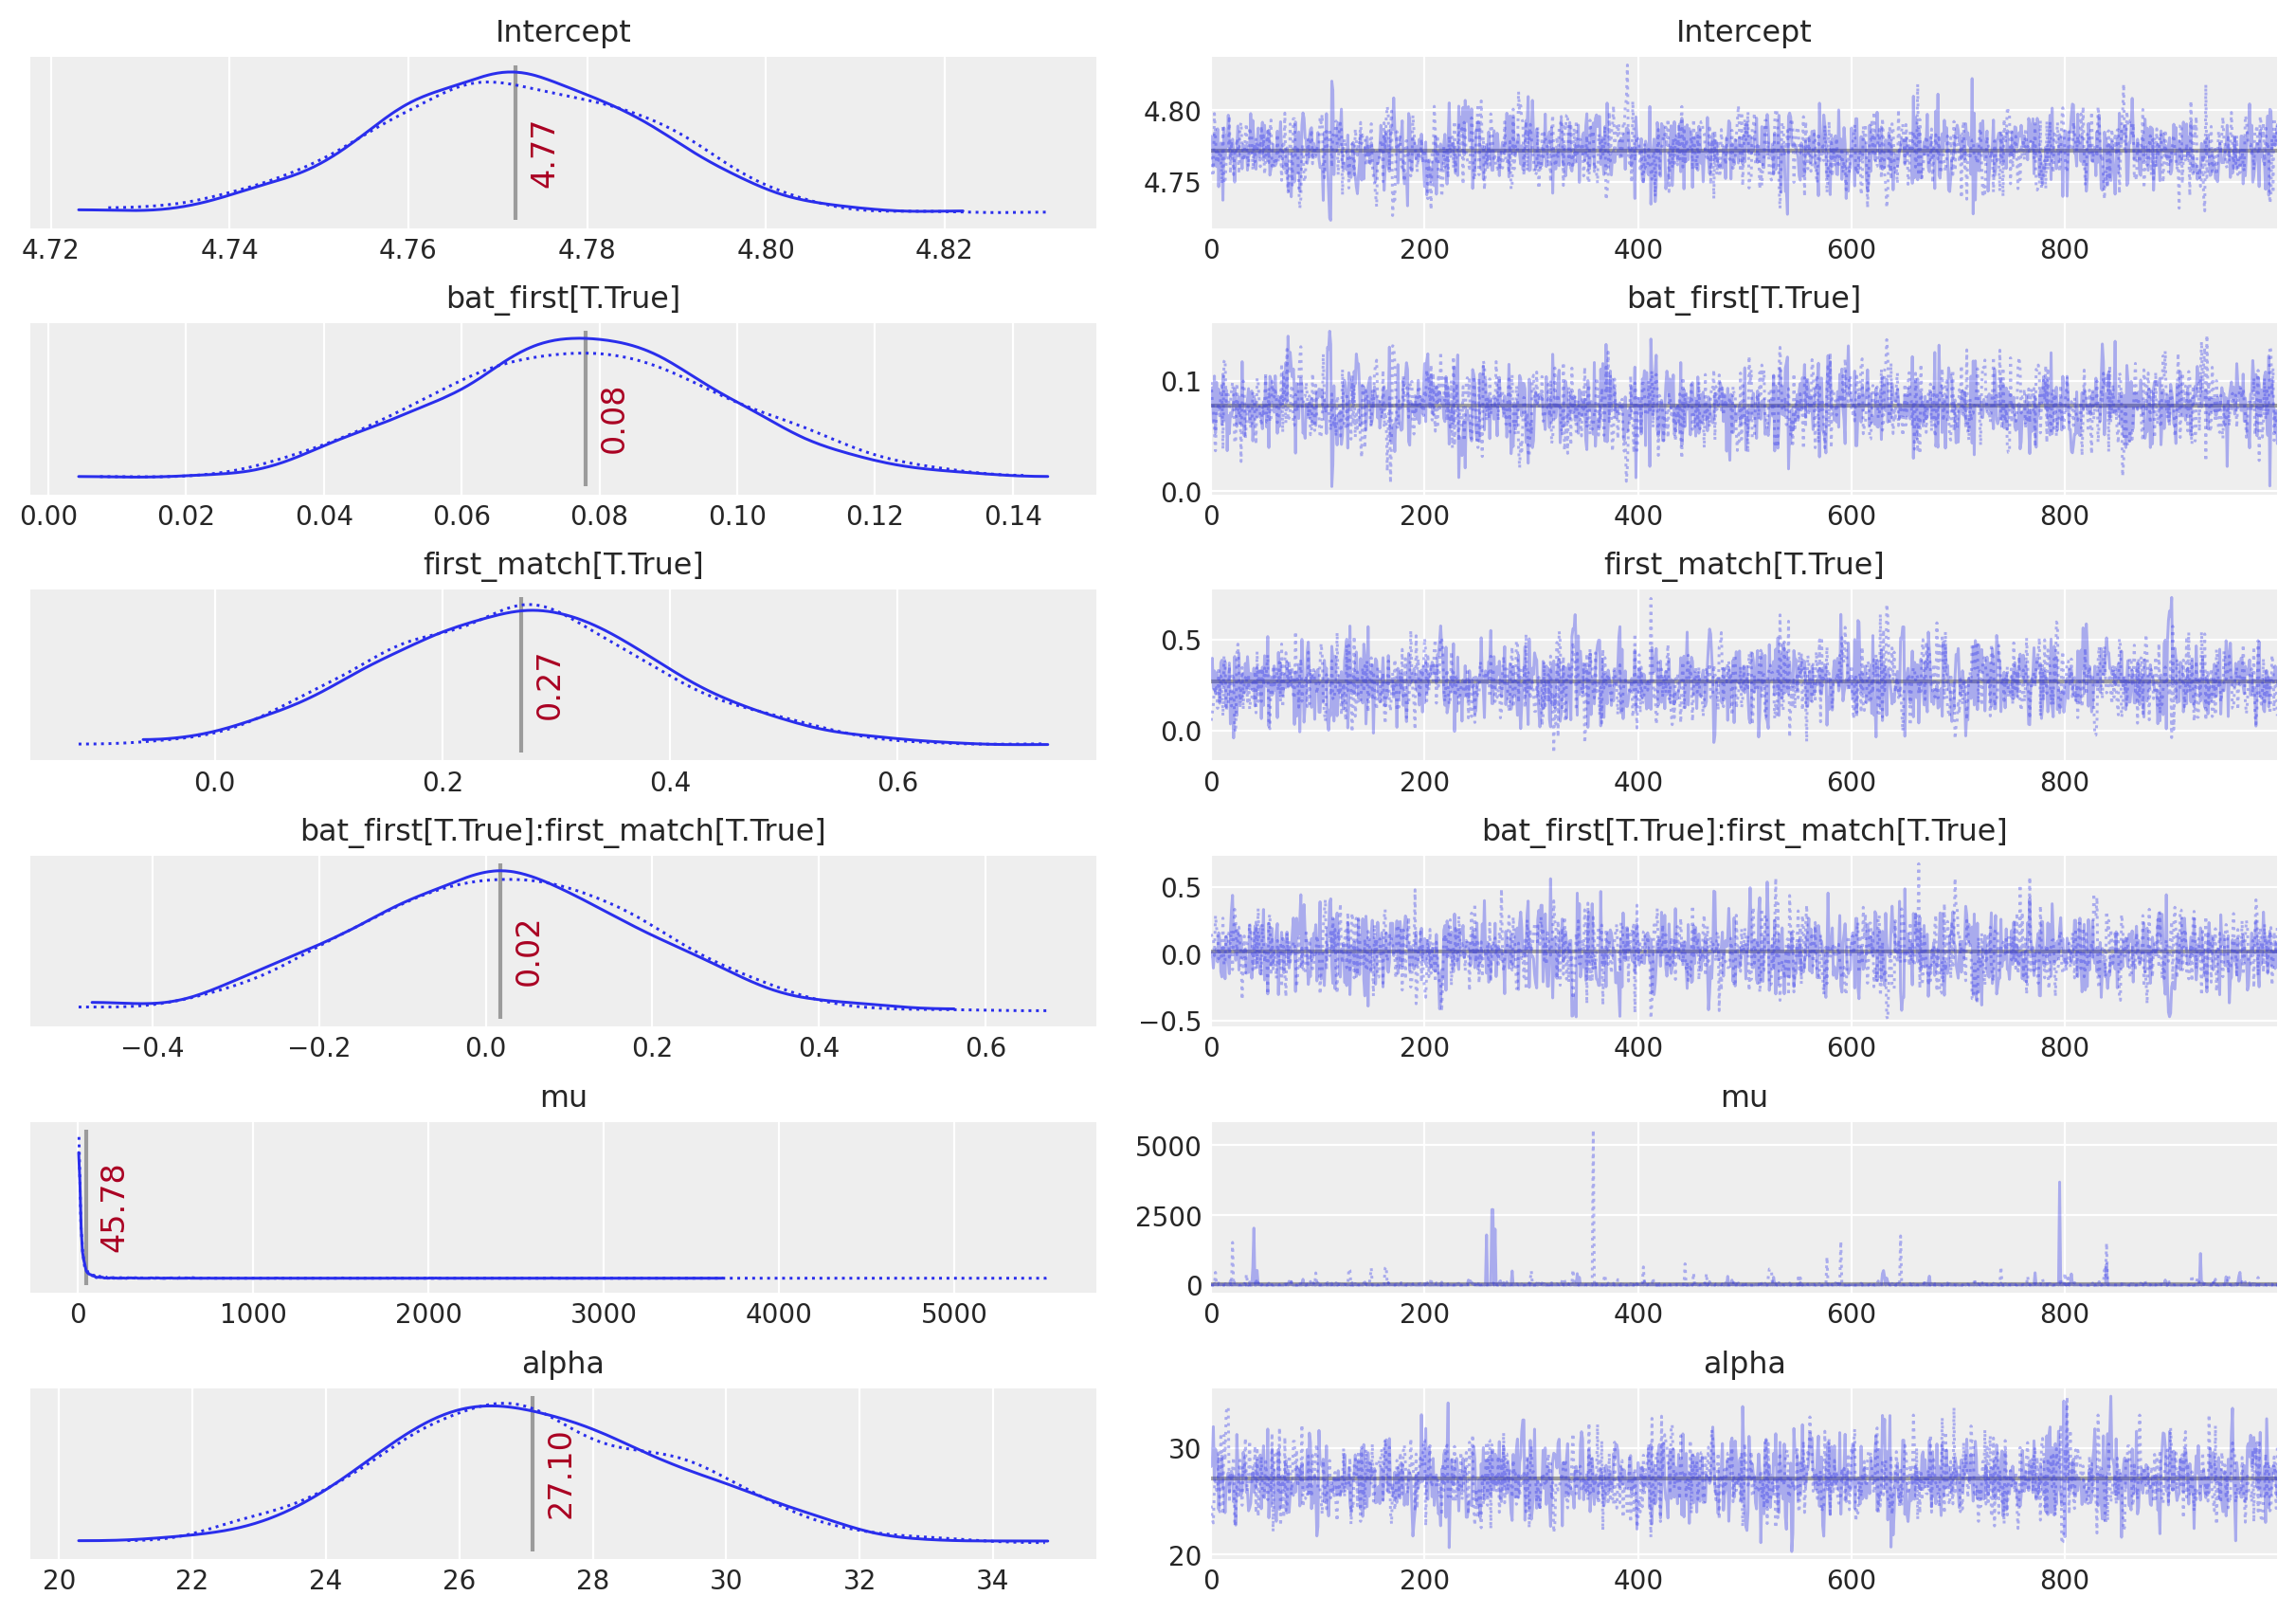

In [24]:
varnames = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace, varnames=varnames)

In [25]:
np.exp(pm.summary(trace, var_names=varnames)[['mean','hdi_3%','hdi_97%']])

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean        hdi_3%  \
Intercept                              1.181553e+02  1.147780e+02   
bat_first[T.True]                      1.081123e+00  1.039770e+00   
first_match[T.True]                    1.308655e+00  1.034585e+00   
bat_first[T.True]:first_match[T.True]  1.017145e+00  7.283308e-01   
mu                                     7.628439e+19  1.010050e+00   
alpha                                  5.874165e+11  1.028549e+10   

                                            hdi_97%  
Intercept                              1.213890e+02  
bat_first[T.True]                      1.126370e+00  
first_match[T.True]                    1.652022e+00  
bat_first[T.True]:first_match[T.True]  1.371630e+00  
mu                                     5.642518e+49  
alpha                                  4.564887e+13

The base number of runs you can expect to score is 118. We expect this should remain constant throughout all three tests. Batting first imparts a 1.08x boost, and if it's the first match of the season it's a whopping 1.311x boost. Both of them together only impart close to a 1.01x boost, suggesting that the two are independent.

In [26]:
formula = 'run_count ~ bat_first + at_home + bat_first:at_home'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=df, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(1000, tune=1250, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, bat_first[T.True]:at_home[T.True], at_home[T.True], bat_first[T.True], Intercept]


Sampling 2 chains for 1_250 tune and 1_000 draw iterations (2_500 + 2_000 draws total) took 12 seconds.


/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stocha

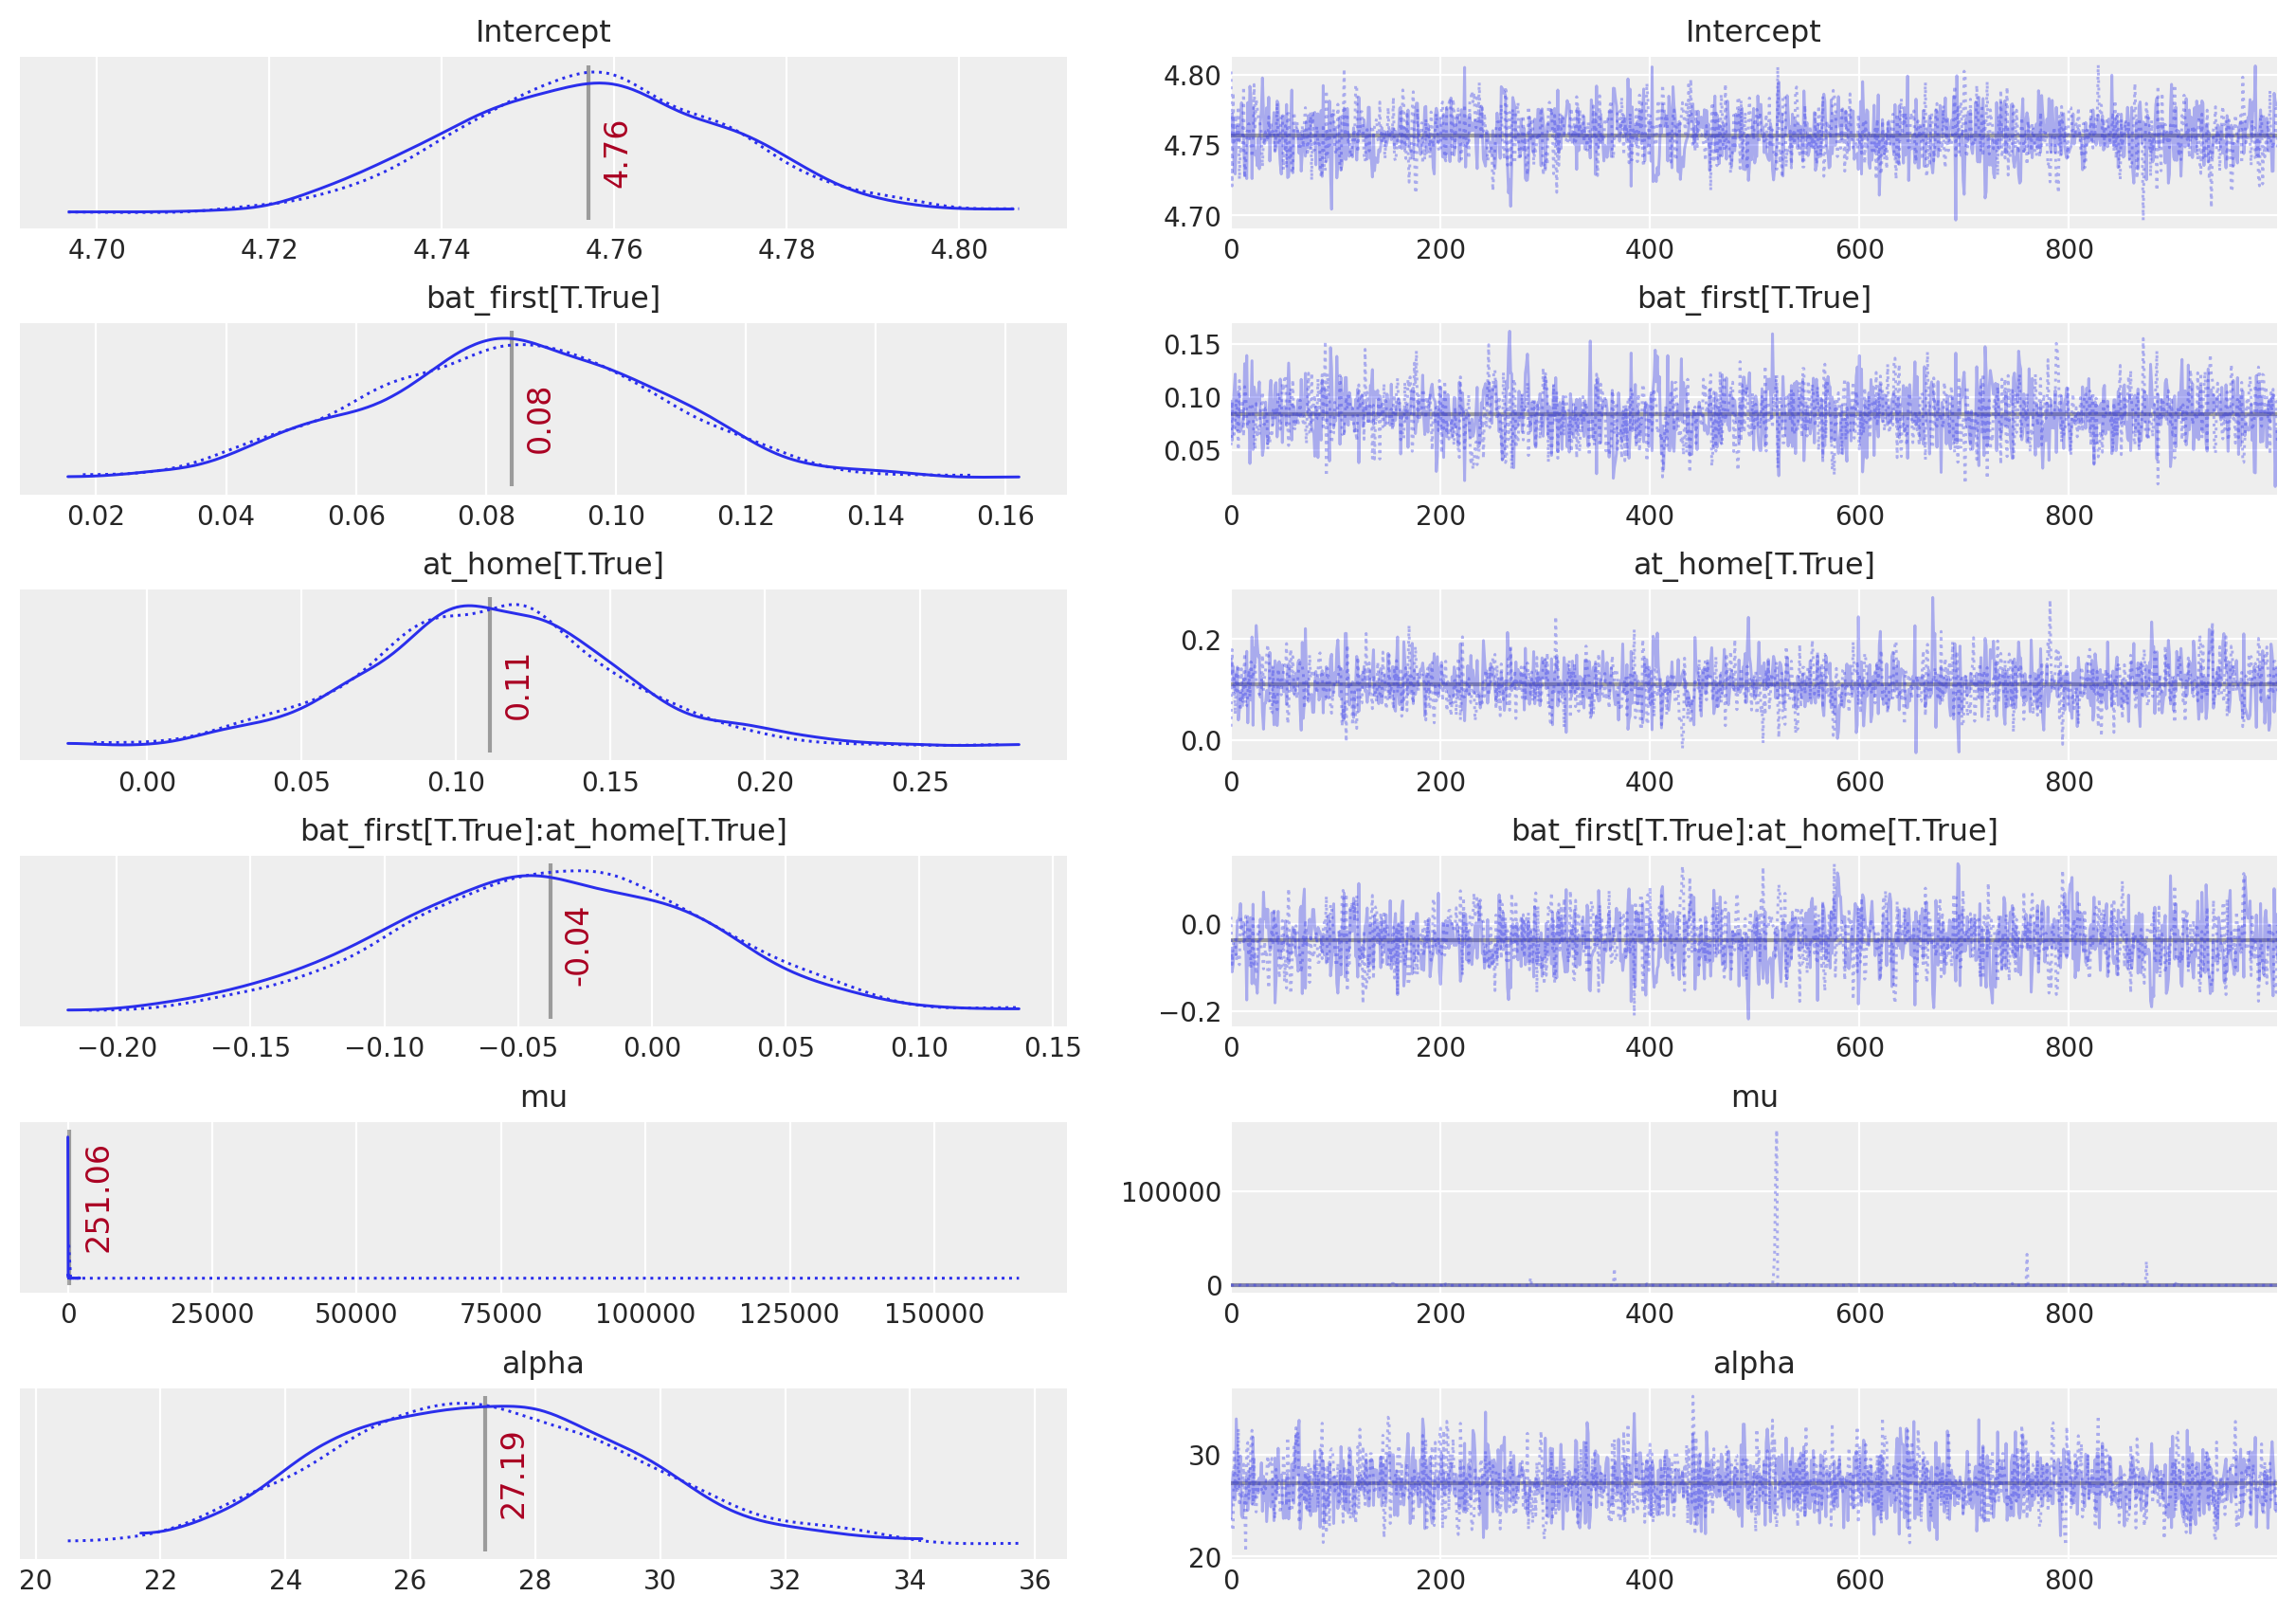

In [27]:
varnames = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace, varnames=varnames)

In [28]:
np.exp(pm.summary(trace, var_names=varnames)[['mean','hdi_3%','hdi_97%']]) 

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean        hdi_3%       hdi_97%
Intercept                           1.163962e+02  1.127305e+02  1.197014e+02
bat_first[T.True]                   1.087629e+00  1.041852e+00  1.132016e+00
at_home[T.True]                     1.117395e+00  1.025315e+00  1.199614e+00
bat_first[T.True]:at_home[T.True]   9.627129e-01  8.676213e-01  1.073581e+00
mu                                 1.080285e+109  1.001001e+00  1.380811e+45
alpha                               6.453122e+11  7.284393e+09  3.996399e+13

This is really interesting. What we notice is that batting first gives us the same boost, and playing at home gives an 11% boost, but together they give a slight decrease. This suggests a slight negative correlation between the two.

In [29]:
formula = 'run_count ~ bat_first + is_final + bat_first:is_final'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=df, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(1000, tune=1250, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, bat_first[T.True]:is_final[T.True], is_final[T.True], bat_first[T.True], Intercept]


Sampling 2 chains for 1_250 tune and 1_000 draw iterations (2_500 + 2_000 draws total) took 11 seconds.


/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stocha

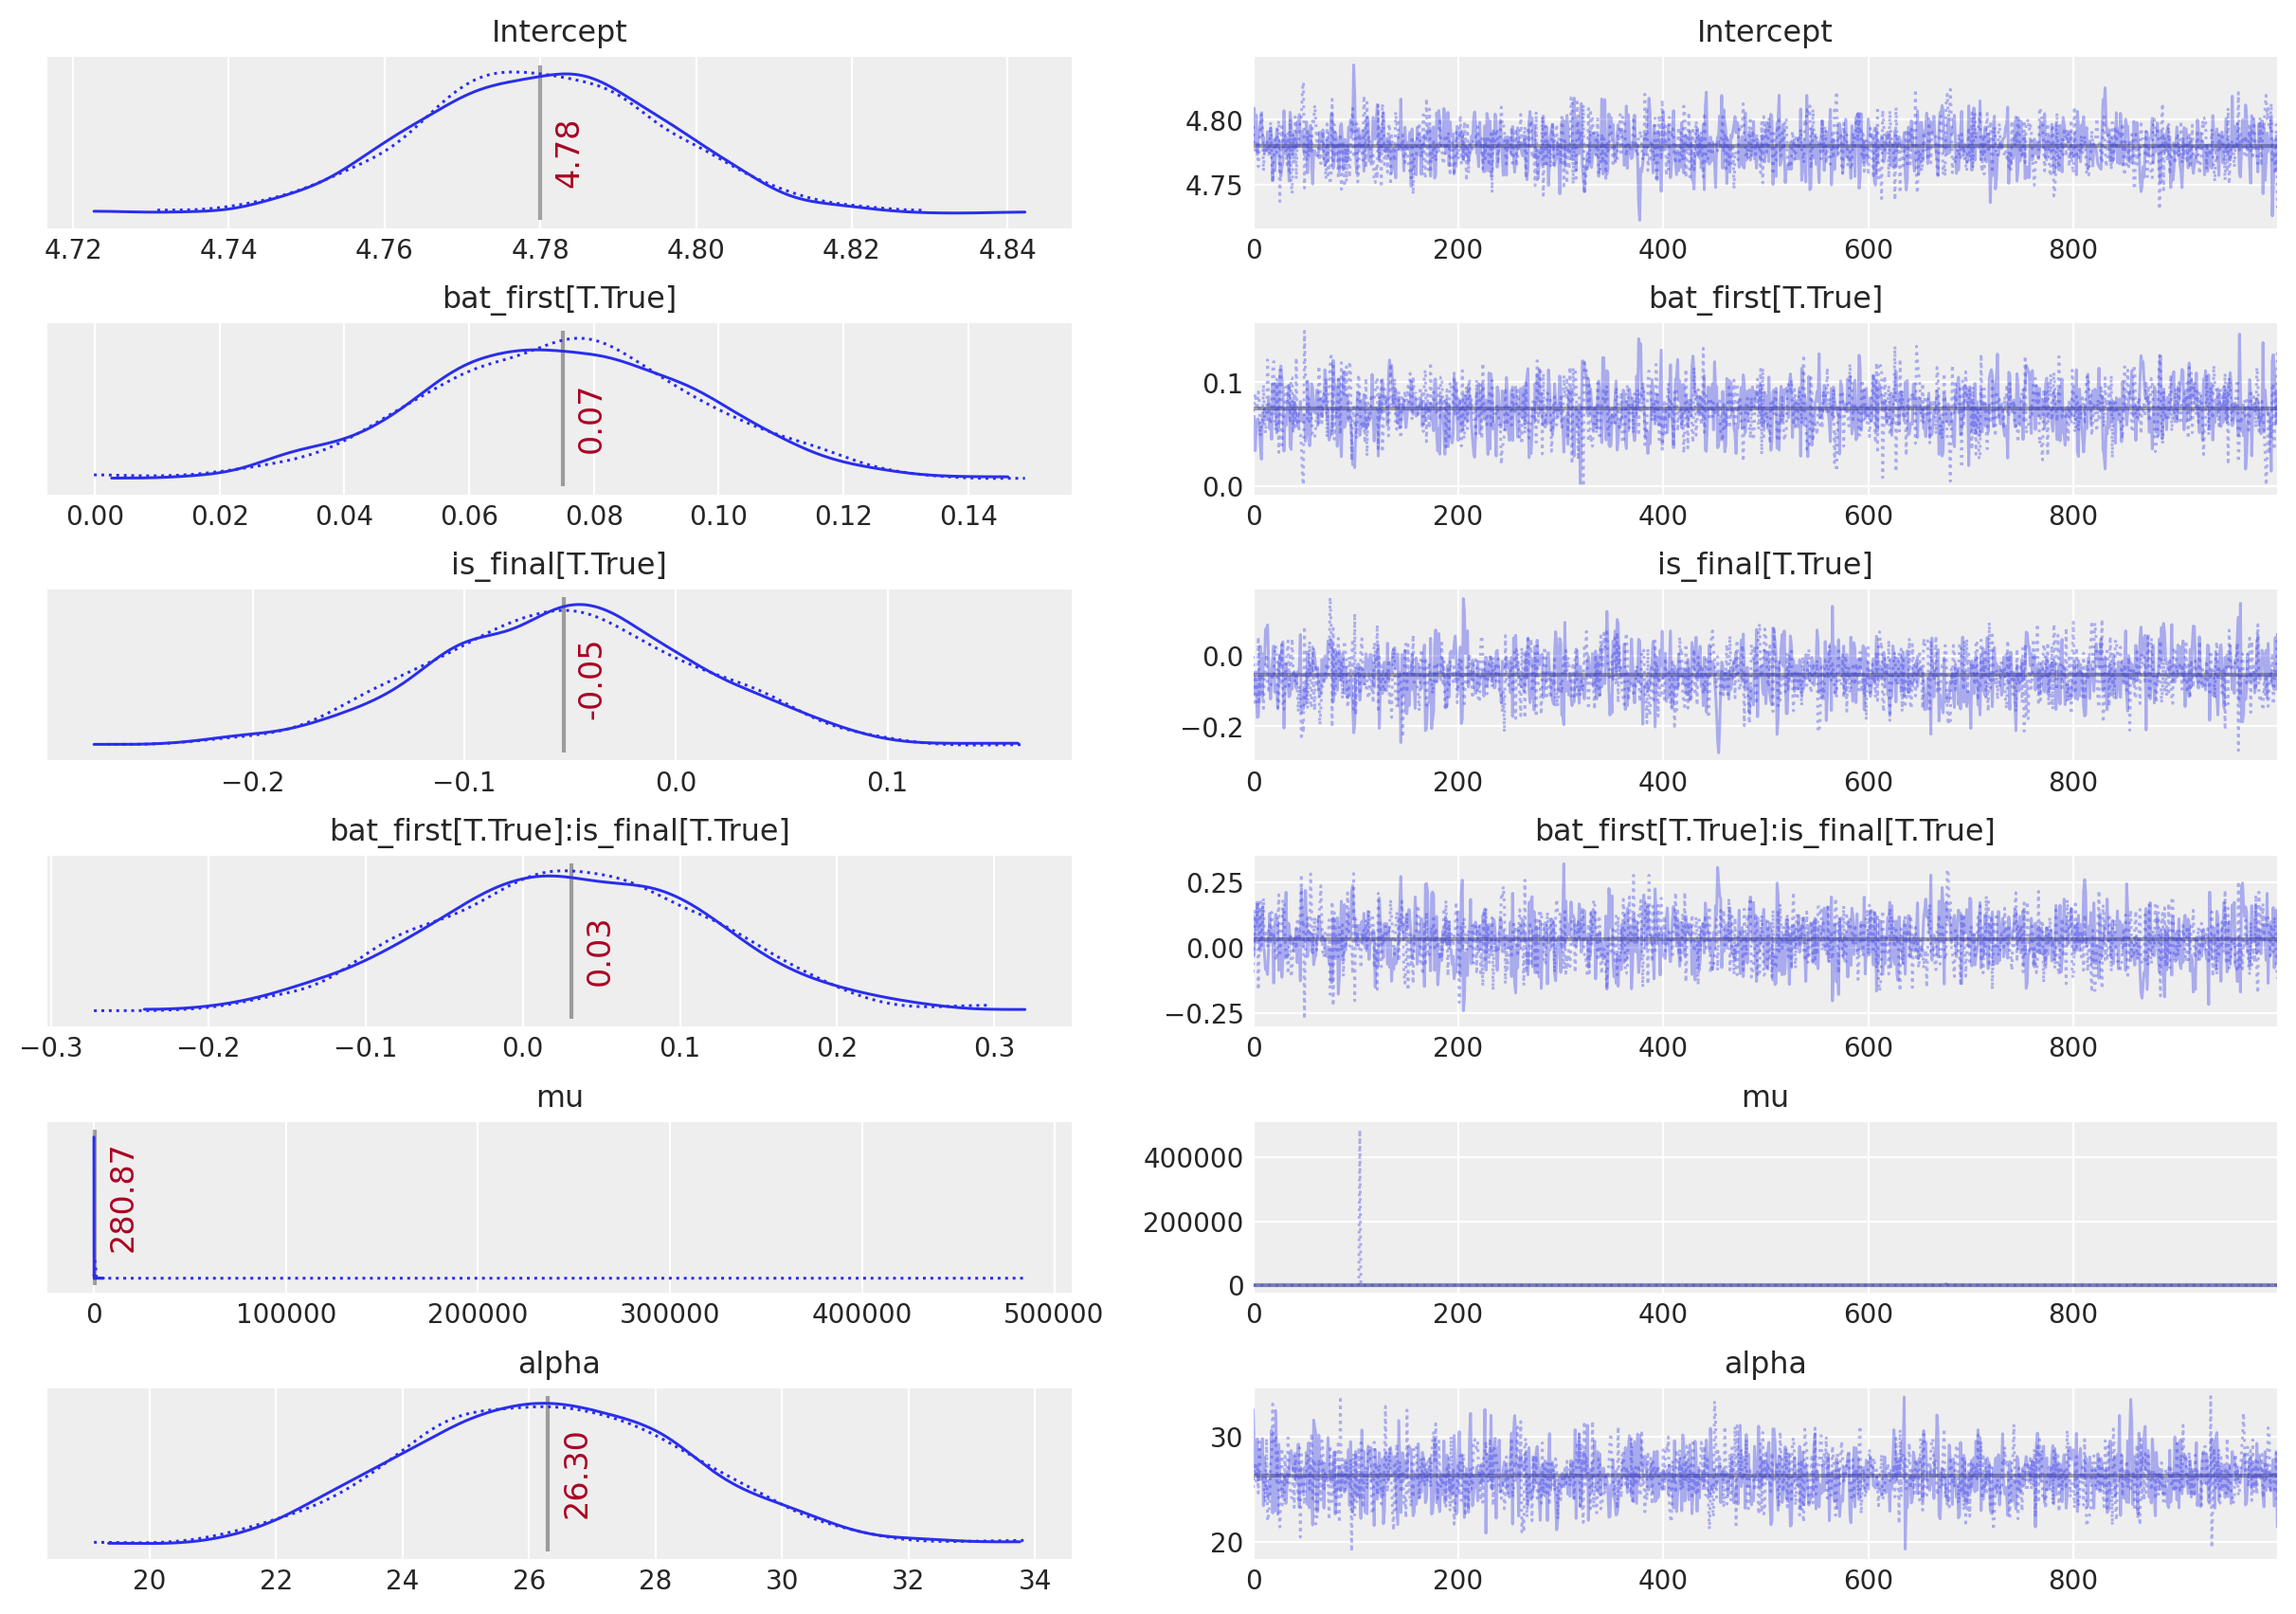

In [30]:
varnames = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace, varnames=varnames)

In [31]:
np.exp(pm.summary(trace, var_names=varnames)[['mean','hdi_3%','hdi_97%']]) 

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean        hdi_3%       hdi_97%
Intercept                            1.191044e+02  1.158157e+02  1.227316e+02
bat_first[T.True]                    1.077884e+00  1.031486e+00  1.120752e+00
is_final[T.True]                     9.483800e-01  8.428216e-01  1.067159e+00
bat_first[T.True]:is_final[T.True]   1.031486e+00  8.702280e-01  1.209250e+00
mu                                  9.518181e+121  1.001001e+00  3.557333e+41
alpha                                2.644717e+11  4.781404e+09  1.530193e+13

These two distributions also show mild dependence, as 1.078963x.9483800=1.023, though there is still some negative correlation.

Lastly, we'll check playing at home against the first match of the season.

In [32]:
formula = 'run_count ~ at_home + is_final + at_home:is_final'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=df, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(1000, tune=1250, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, at_home[T.True]:is_final[T.True], is_final[T.True], at_home[T.True], Intercept]


Sampling 2 chains for 1_250 tune and 1_000 draw iterations (2_500 + 2_000 draws total) took 11 seconds.


/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stocha

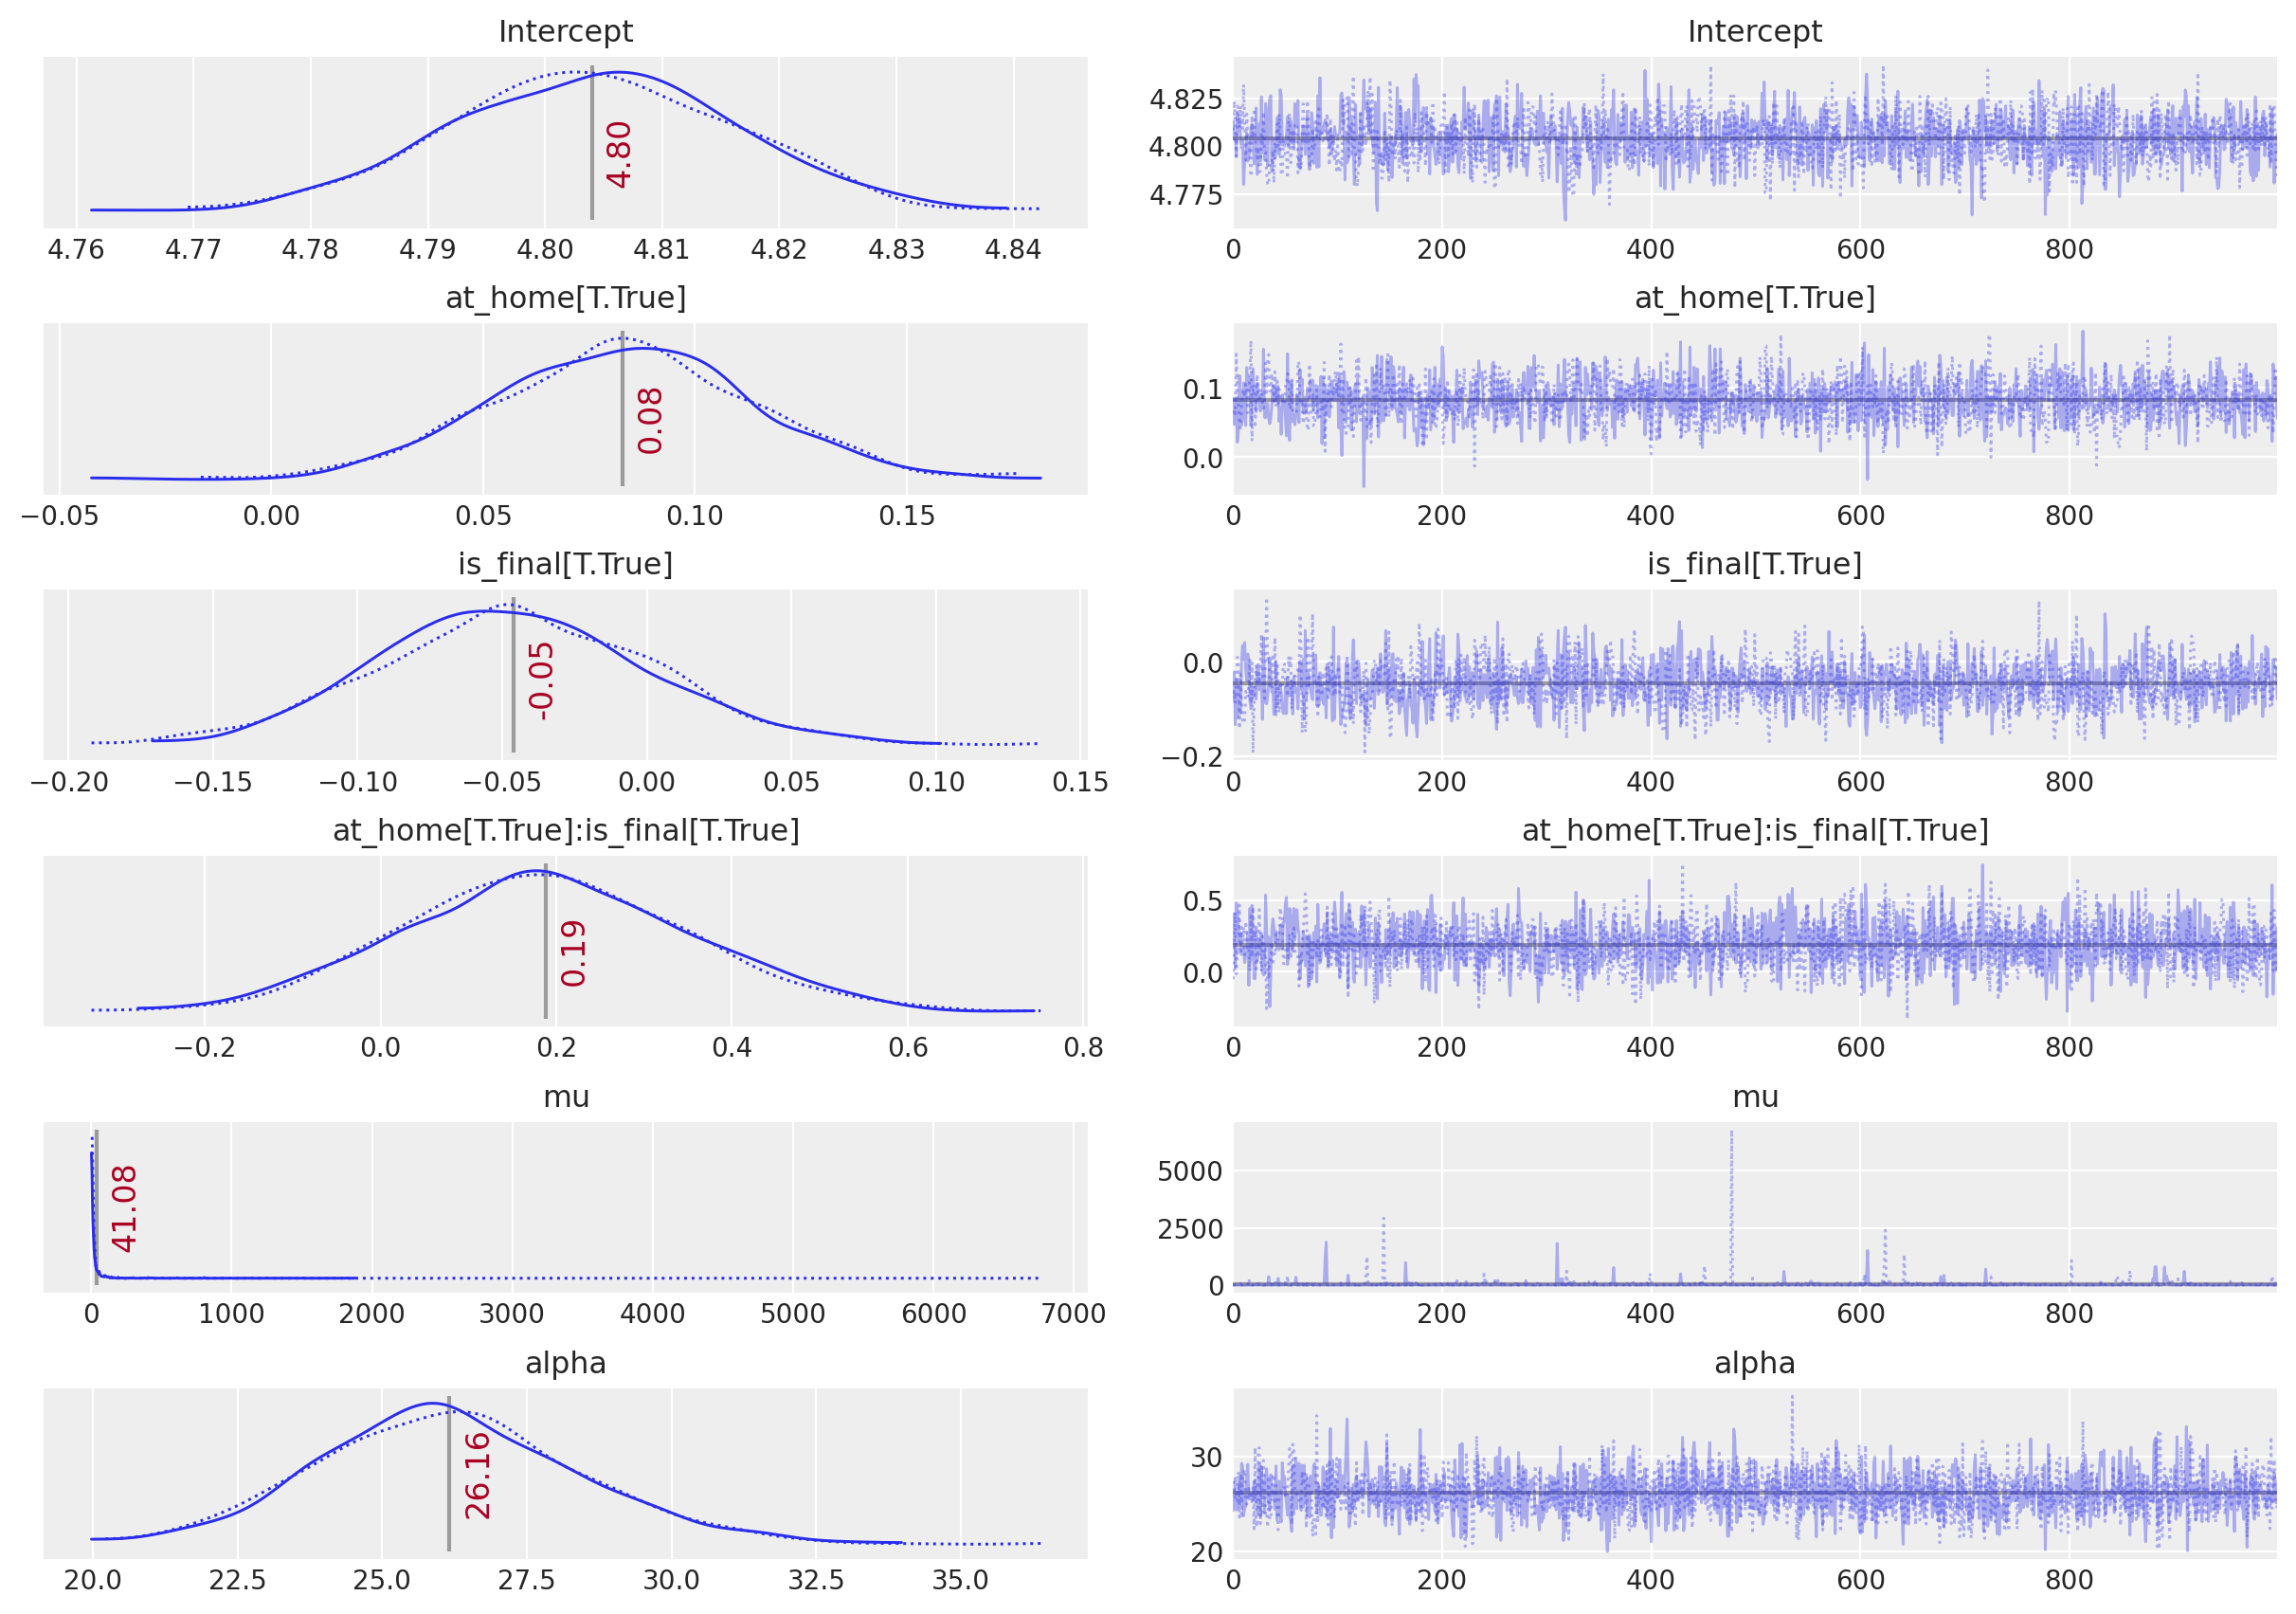

In [33]:
varnames = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace, varnames=varnames)

In [34]:
np.exp(pm.summary(trace, var_names=varnames)[['mean','hdi_3%','hdi_97%']]) 

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean        hdi_3%       hdi_97%
Intercept                         1.219974e+02  1.192235e+02  1.248359e+02
at_home[T.True]                   1.086542e+00  1.028396e+00  1.149124e+00
is_final[T.True]                  9.550420e-01  8.719702e-01  1.040811e+00
at_home[T.True]:is_final[T.True]  1.206834e+00  8.860340e-01  1.617691e+00
mu                                6.952167e+17  1.011061e+00  1.771224e+45
alpha                             2.299206e+11  2.797522e+09  1.419626e+13

Ah, look! That is a pretty positive correlation - suggesting that there is little independence between playing at home at the final. This lines up with our intuition that playing at home definitely incurs an advantage (and even more so when finals trepidation sets in).

We can take several things away from this analysis:
- a combination of batting first and playing the first match of the season will have the highest impact on the score of runs of a given innings.
- playing a match in the final will negatively impact overall runs scored.
- batting first can overcome the negative impact of it being a final match.
- similarly, playing at home during the final seems to overcome the negative impact of the match being a final.

As an extra, and just for fun, let's see if batting first whilst playing at home in the final has a mean...

In [35]:
df.groupby(['bat_first', 'at_home', 'is_final'])['run_count'].agg(['mean', 'var'])

mean         var
bat_first at_home is_final                        
False     False   False     117.270440  581.464374
                  True      105.818182  617.963636
          True    False     128.566667  569.978161
                  True      151.000000   18.000000
True      False   False     126.698718  707.515095
                  True      125.538462  574.769231
          True    False     136.393939  889.996212

What a lucky team! Unsurprisingly, the condition of False-False-True imparts an awful outcome.

Let's see what it does to our model...

In [36]:
formula = 'run_count ~ bat_first + at_home + is_final + bat_first:at_home:is_final'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=df, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(1000, tune=1250, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, bat_first[T.True]:at_home[T.True]:is_final[True], bat_first[T.True]:at_home[T.True]:is_final[False], at_home[T.True]:is_final[T.True], bat_first[T.True]:is_final[T.True], is_final[T.True], at_home[T.True], bat_first[T.True], Intercept]


Sampling 2 chains for 1_250 tune and 1_000 draw iterations (2_500 + 2_000 draws total) took 18 seconds.


/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexmcneill/repos/wbbl-stocha

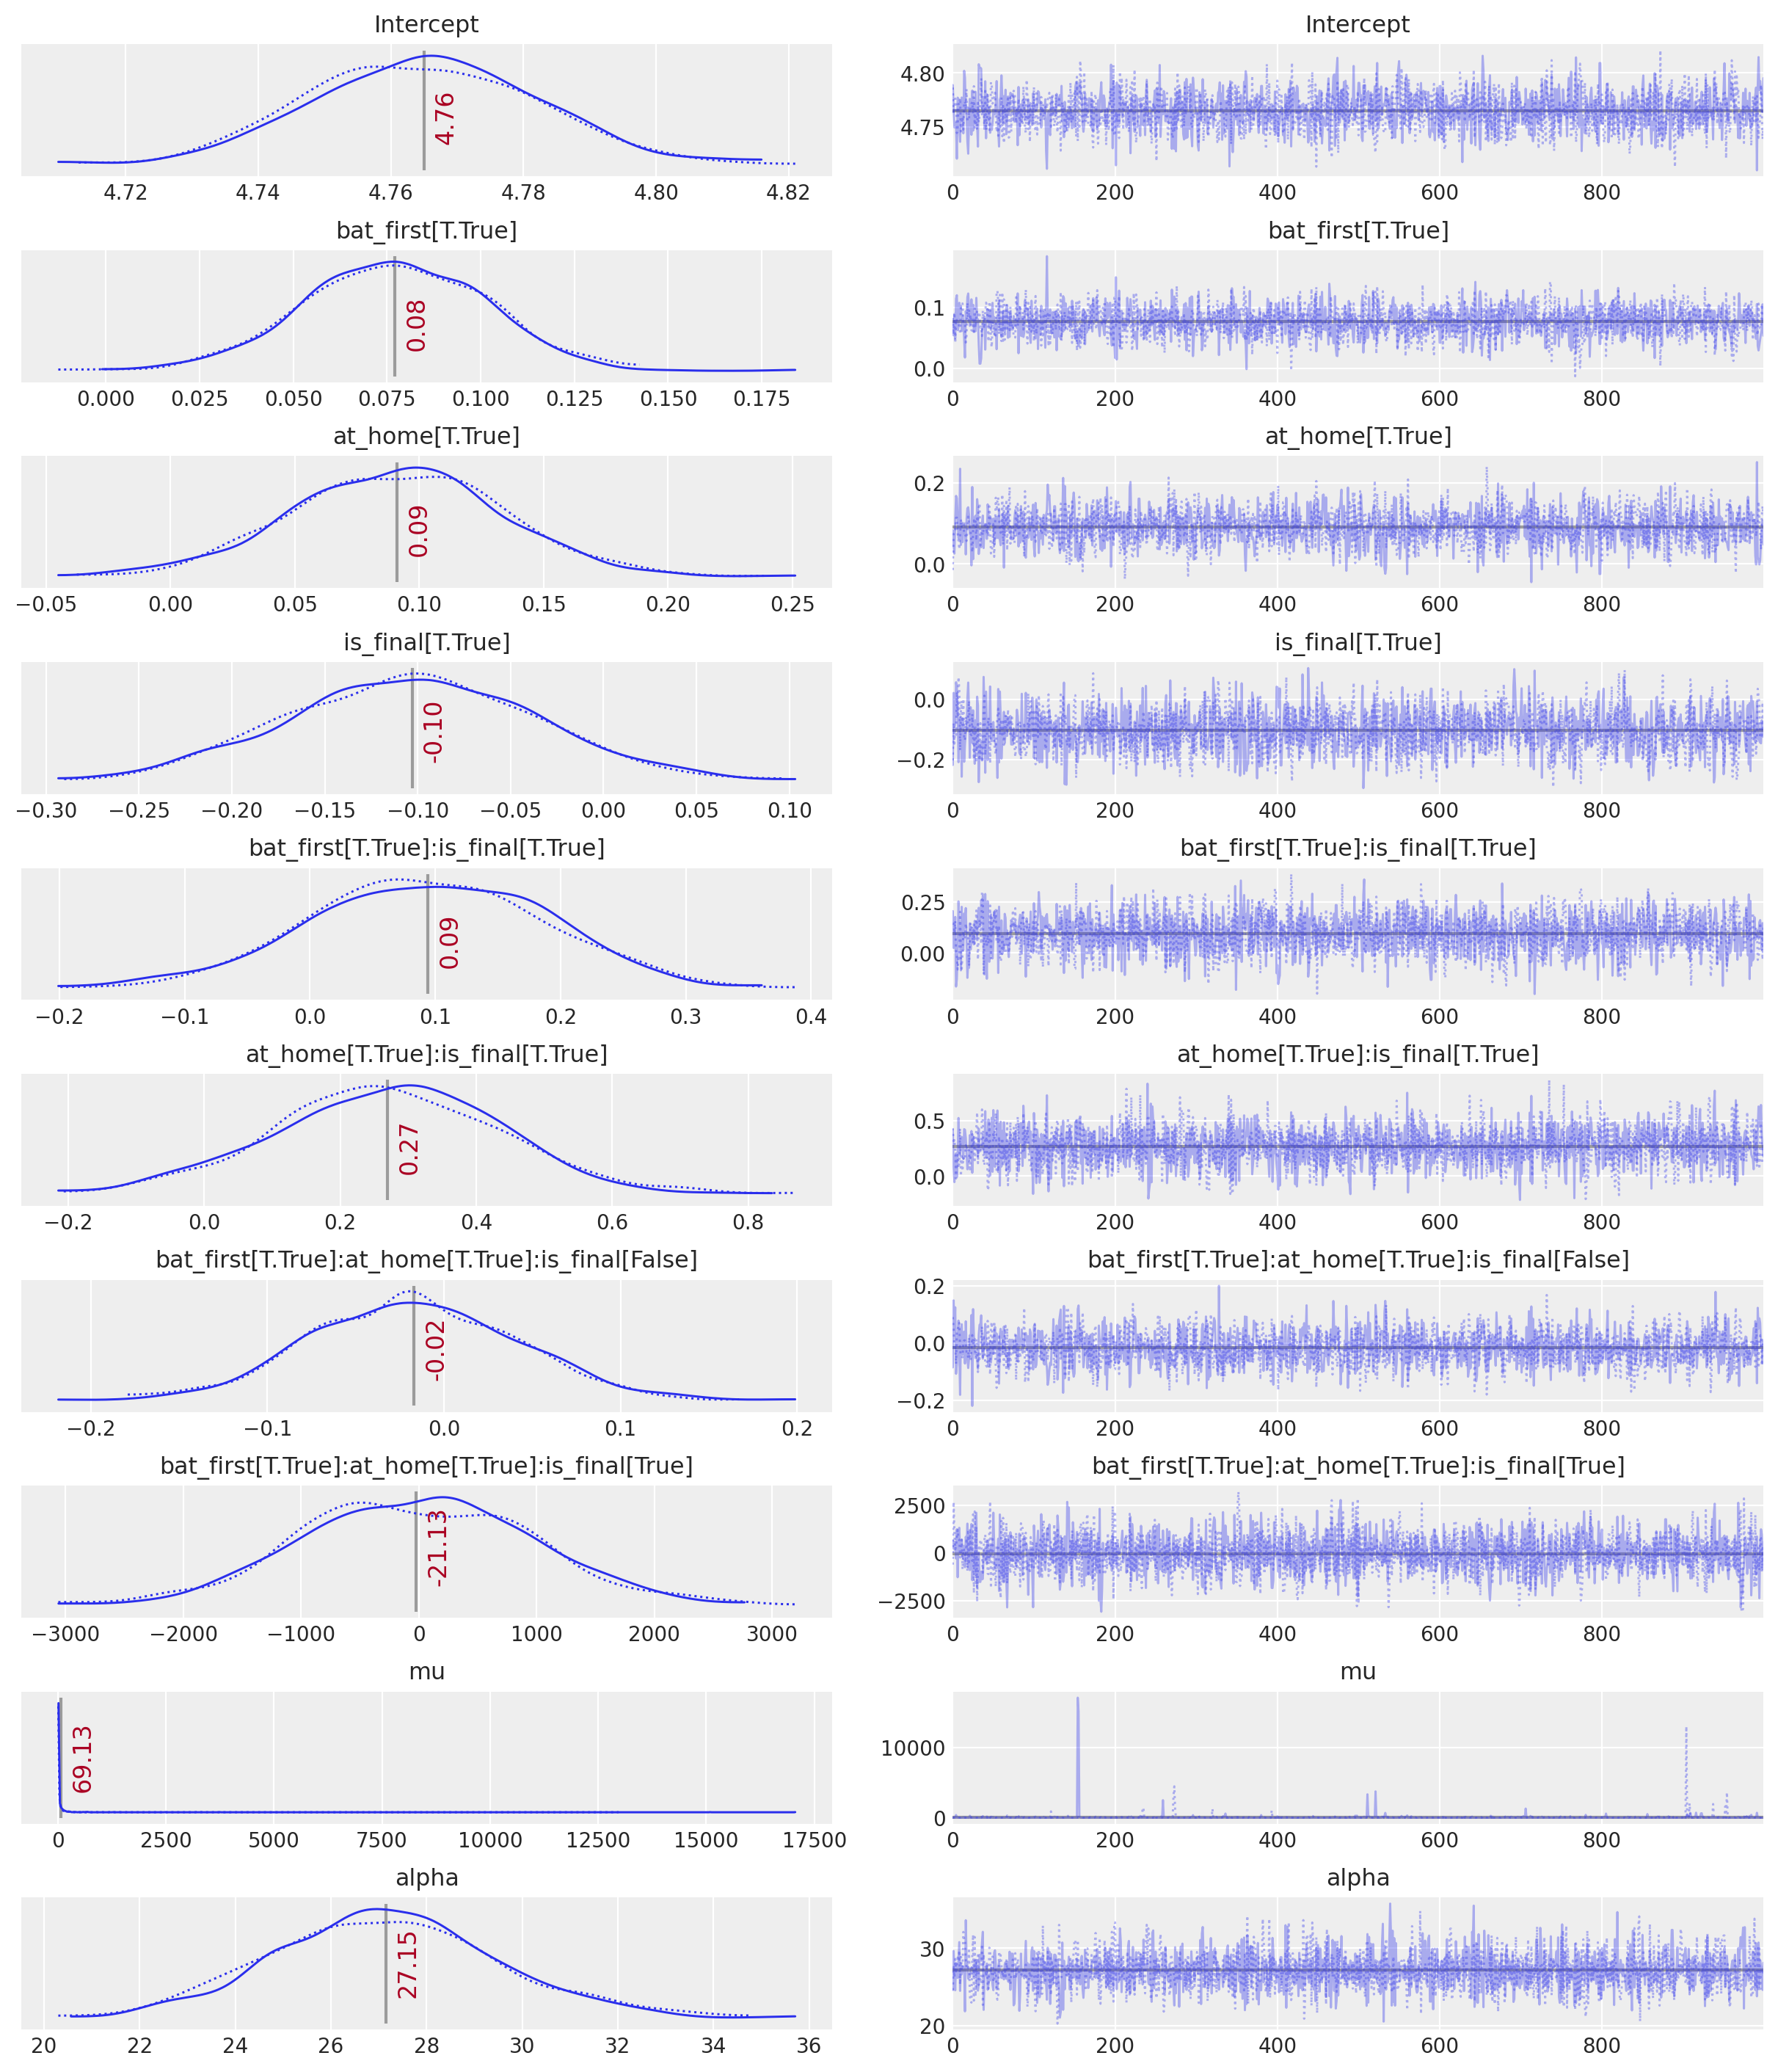

In [37]:
varnames = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
plot_traces(trace, varnames=varnames)

In [38]:
np.exp(pm.summary(trace, var_names=varnames)[['mean','hdi_3%','hdi_97%']]) 

/Users/alexmcneill/repos/wbbl-stochastics/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean        hdi_3%  \
Intercept                                          1.173311e+02  1.136360e+02   
bat_first[T.True]                                  1.080042e+00  1.029425e+00   
at_home[T.True]                                    1.095269e+00  1.012072e+00   
is_final[T.True]                                   9.021270e-01  7.961243e-01   
bat_first[T.True]:is_final[T.True]                 1.098560e+00  9.333267e-01   
at_home[T.True]:is_final[T.True]                   1.308655e+00  9.474321e-01   
bat_first[T.True]:at_home[T.True]:is_final[False]  9.831437e-01  8.886961e-01   
bat_first[T.True]:at_home[T.True]:is_final[True]   6.644909e-10  0.000000e+00   
mu                                                 1.052794e+30  1.005013e+00   
alpha                                              6.200091e+11  8.010348e+09   

                                                        hdi_97%  
Intercept                                          1.210253e+02  
bat_first[T.True]                                  1.126370e+00  
at_home[T.True]                                    1.185305e+00  
is_final[T.True]                                   1.027368e+00  
bat_first[T.True]:is_final[T.True]                 1.319166e+00  
at_home[T.True]:is_final[T.True]                   1.780688e+00  
bat_first[T.True]:at_home[T.True]:is_final[False]  1.099659e+00  
bat_first[T.True]:at_home[T.True]:is_final[True]            inf  
mu                                                 7.484393e+55  
alpha                                              5.716712e+13

Looks like our independence is completely out the window for these three variables together. We would expect 1.06x the base rate of 117, except that we get .347x! Looks like you really do end up stacking the odds in your favour for the final if you get lucky enough to bat first and play at home. Although we'd need more samples to be really sure.